# Genotypes Data Analysis _ Random Forest

This notebook reads and analyzes the genotypes.txt file, which contains genetic data with IDs in the first column and allele pairs in the subsequent columns. The file format is space-separated with specific patterns:
- First column contains IDs
- Alleles in each bi-allele pair are separated by one space
- Different allele pairs are separated by two spaces

In [ ]:
!pip install timeout-decorator


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
!pip install lightgbm


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time

from scipy.spatial.distance import pdist, squareform

from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import make_pipeline
import statsmodels.api as sm
from lightgbm import LGBMRegressor
import logging
import gc
from tqdm import tqdm
from sklearn.model_selection import KFold, cross_validate
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import mutual_info_regression

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LassoCV, ElasticNetCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
import timeout_decorator



# Set display options
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 1000)

## Reading the Genotypes File

The file has a specific format where:
- The data is space-separated (not tab-separated)
- The two columns for each bi-allele are separated by one space
- Each pair of alleles is separated by two spaces

In [7]:

genotypes_df = pd.read_csv('genotypes.txt', sep='  ', nrows=5,header=None)
genotypes_df = genotypes_df.drop(index=0)
print(genotypes_df.head())
print(genotypes_df[1])


   0     1     2     3     4     5     6     7     8     9      ... 10022 10023 10024 10025 10026 10027 10028 10029 10030 10031
1      2   1 2   1 2   1 1   1 2   1 2   1 2   1 2   1 2   2 2  ...   1 1   1 2   1 1   1 2   2 2   2 2   1 1   1 2   1 1   1 2
2      3   1 2   2 2   1 1   1 2   1 2   1 2   2 2   1 1   1 1  ...   1 1   1 2   1 1   2 2   1 1   1 2   1 1   1 2   1 2   2 2
3      4   2 2   2 2   1 1   1 1   1 2   1 1   2 2   1 1   1 2  ...   1 1   1 2   1 1   1 2   2 2   2 2   1 1   1 2   1 2   2 2
4      5   2 2   1 2   1 2   1 2   2 2   2 2   1 2   2 2   2 2  ...   1 1   2 2   1 1   1 1   2 2   2 2   1 1   1 1   1 1   2 2

[4 rows x 10032 columns]
1    1 2
2    1 2
3    2 2
4    2 2
Name: 1, dtype: object


/var/folders/55/nhkl64cx1vlbkvbc540p14700000gn/T/ipykernel_55077/2802912486.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  genotypes_df = pd.read_csv('genotypes.txt', sep='  ', nrows=5,header=None)


In [8]:

genotypes_df = pd.read_csv('genotypes.txt', sep='  ', header=None,  engine='python')

genotypes_df = genotypes_df.drop(genotypes_df.columns[0], axis=1)

# Replace values as specified
genotypes_df = genotypes_df.replace({'1 1': 0, '1 2': 1, '2 2': 2})

print(genotypes_df.head())
print(genotypes_df.dtypes.unique())
print(genotypes_df[1])
print(genotypes_df.shape)

/var/folders/55/nhkl64cx1vlbkvbc540p14700000gn/T/ipykernel_55077/2134314628.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  genotypes_df = genotypes_df.replace({'1 1': 0, '1 2': 1, '2 2': 2})


   1      2      3      4      5      6      7      8      9      10     ...  10022  10023  10024  10025  10026  10027  10028  10029  10030  10031
0      2      2      1      1      2      1      2      1      1      0  ...      1      0      0      2      2      2      0      1      1      2
1      1      1      0      1      1      1      1      1      2      0  ...      0      1      0      1      2      2      0      1      0      1
2      1      2      0      1      1      1      2      0      0      0  ...      0      1      0      2      0      1      0      1      1      2
3      2      2      0      0      1      0      2      0      1      0  ...      0      1      0      1      2      2      0      1      1      2
4      2      1      1      1      2      2      1      2      2      0  ...      0      2      0      0      2      2      0      0      0      2

[5 rows x 10031 columns]
[dtype('int64')]
0       2
1       1
2       1
3       2
4       2
       ..
3221    1
3222 

In [9]:
marker_info_df = pd.read_csv('marker-info.txt', sep=' ', header=None, index_col=0)
marker_info_df = marker_info_df.drop(1, axis=1)
marker_info_df = marker_info_df.rename(columns={2: 'chromosome', 3: 'position'})
marker_info_df.head()

,chromosome,position
0,,
1,1,88671
2,1,114576
3,1,115699
4,1,155552
5,1,175528


In [10]:
marker_info_df['col_label'] = "chr_"+marker_info_df['chromosome'].astype(str)+"_pos_"+marker_info_df['position'].astype(str)
marker_info_df.drop(columns=['chromosome', 'position'], inplace=True)
marker_info_df

,col_label
0,
1,chr_1_pos_88671
2,chr_1_pos_114576
3,chr_1_pos_115699
4,chr_1_pos_155552
5,chr_1_pos_175528
...,...
10027,chr_5_pos_99426456
10028,chr_5_pos_99471982
10029,chr_5_pos_99610295


In [11]:
genotypes_df.columns = marker_info_df['col_label']

In [12]:
genotypes_df

col_label,chr_1_pos_88671,chr_1_pos_114576,chr_1_pos_115699,chr_1_pos_155552,chr_1_pos_175528,chr_1_pos_181280,chr_1_pos_201670,chr_1_pos_261558,chr_1_pos_277357,chr_1_pos_298436,...,chr_5_pos_99117225,chr_5_pos_99141416,chr_5_pos_99172858,chr_5_pos_99213046,chr_5_pos_99233297,chr_5_pos_99426456,chr_5_pos_99471982,chr_5_pos_99610295,chr_5_pos_99766772,chr_5_pos_99812870
0,2,2,1,1,2,1,2,1,1,0,...,1,0,0,2,2,2,0,1,1,2
1,1,1,0,1,1,1,1,1,2,0,...,0,1,0,1,2,2,0,1,0,1
2,1,2,0,1,1,1,2,0,0,0,...,0,1,0,2,0,1,0,1,1,2
3,2,2,0,0,1,0,2,0,1,0,...,0,1,0,1,2,2,0,1,1,2
4,2,1,1,1,2,2,1,2,2,0,...,0,2,0,0,2,2,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3221,1,1,0,1,2,1,1,1,1,0,...,0,2,0,1,1,1,0,1,1,2
3222,1,0,0,2,2,2,0,2,2,0,...,1,0,0,2,1,2,0,0,0,2
3223,1,1,0,1,2,1,1,1,1,0,...,0,2,0,1,1,1,0,1,1,2
3224,1,0,0,2,2,2,0,2,2,0,...,1,1,0,2,1,1,0,1,1,2


In [13]:
pedigree_df = pd.read_csv('pedigree.txt', sep=' ', header=None, index_col=0)
pedigree_df = pedigree_df.drop(3, axis=1)
pedigree_df = pedigree_df.rename(columns={1: 'MP', 2: 'FP',4:'SEX'})
pedigree_df.head()

,MP,FP,SEX
0,,,
1,0,0,M
2,0,0,M
3,0,0,M
4,0,0,M
5,0,0,M


In [14]:
pedigree_df['col_label'] = "MP_"+pedigree_df['MP'].astype(str)+"_FP_"+pedigree_df['FP'].astype(str)+"_SEX_"+pedigree_df['SEX'].astype(str)
pedigree_df.drop(columns=['MP', 'FP', 'SEX'], inplace=True)
pedigree_df

,col_label
0,
1,MP_0_FP_0_SEX_M
2,MP_0_FP_0_SEX_M
3,MP_0_FP_0_SEX_M
4,MP_0_FP_0_SEX_M
5,MP_0_FP_0_SEX_M
...,...
3222,MP_1590_FP_2057_SEX_F
3223,MP_1590_FP_2057_SEX_M
3224,MP_1590_FP_2057_SEX_M


In [15]:
genotypes_df.index = list(pedigree_df['col_label'])
genotypes_df

col_label,chr_1_pos_88671,chr_1_pos_114576,chr_1_pos_115699,chr_1_pos_155552,chr_1_pos_175528,chr_1_pos_181280,chr_1_pos_201670,chr_1_pos_261558,chr_1_pos_277357,chr_1_pos_298436,...,chr_5_pos_99117225,chr_5_pos_99141416,chr_5_pos_99172858,chr_5_pos_99213046,chr_5_pos_99233297,chr_5_pos_99426456,chr_5_pos_99471982,chr_5_pos_99610295,chr_5_pos_99766772,chr_5_pos_99812870
MP_0_FP_0_SEX_M,2,2,1,1,2,1,2,1,1,0,...,1,0,0,2,2,2,0,1,1,2
MP_0_FP_0_SEX_M,1,1,0,1,1,1,1,1,2,0,...,0,1,0,1,2,2,0,1,0,1
MP_0_FP_0_SEX_M,1,2,0,1,1,1,2,0,0,0,...,0,1,0,2,0,1,0,1,1,2
MP_0_FP_0_SEX_M,2,2,0,0,1,0,2,0,1,0,...,0,1,0,1,2,2,0,1,1,2
MP_0_FP_0_SEX_M,2,1,1,1,2,2,1,2,2,0,...,0,2,0,0,2,2,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MP_1590_FP_2057_SEX_F,1,1,0,1,2,1,1,1,1,0,...,0,2,0,1,1,1,0,1,1,2
MP_1590_FP_2057_SEX_M,1,0,0,2,2,2,0,2,2,0,...,1,0,0,2,1,2,0,0,0,2
MP_1590_FP_2057_SEX_M,1,1,0,1,2,1,1,1,1,0,...,0,2,0,1,1,1,0,1,1,2
MP_1590_FP_2057_SEX_M,1,0,0,2,2,2,0,2,2,0,...,1,1,0,2,1,1,0,1,1,2


In [16]:
genotypes_df.to_csv('raw_data_uncut.csv', header=True)

In [17]:
unique_values = []
for col in genotypes_df:
    unique_values.extend(genotypes_df[col].unique())
list(set(unique_values))

[np.int64(0), np.int64(1), np.int64(2)]

### NO MISSING VALUES

In [19]:
genotypes_df_sub = genotypes_df.iloc[:2326, :]
genotypes_df_sub
genotypes_df_sub.index = list(pedigree_df['col_label'][:2326])
genotypes_df_sub

col_label,chr_1_pos_88671,chr_1_pos_114576,chr_1_pos_115699,chr_1_pos_155552,chr_1_pos_175528,chr_1_pos_181280,chr_1_pos_201670,chr_1_pos_261558,chr_1_pos_277357,chr_1_pos_298436,...,chr_5_pos_99117225,chr_5_pos_99141416,chr_5_pos_99172858,chr_5_pos_99213046,chr_5_pos_99233297,chr_5_pos_99426456,chr_5_pos_99471982,chr_5_pos_99610295,chr_5_pos_99766772,chr_5_pos_99812870
MP_0_FP_0_SEX_M,2,2,1,1,2,1,2,1,1,0,...,1,0,0,2,2,2,0,1,1,2
MP_0_FP_0_SEX_M,1,1,0,1,1,1,1,1,2,0,...,0,1,0,1,2,2,0,1,0,1
MP_0_FP_0_SEX_M,1,2,0,1,1,1,2,0,0,0,...,0,1,0,2,0,1,0,1,1,2
MP_0_FP_0_SEX_M,2,2,0,0,1,0,2,0,1,0,...,0,1,0,1,2,2,0,1,1,2
MP_0_FP_0_SEX_M,2,1,1,1,2,2,1,2,2,0,...,0,2,0,0,2,2,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MP_1150_FP_1125_SEX_M,1,1,1,2,2,2,1,2,2,0,...,0,2,0,1,1,1,0,1,1,2
MP_1150_FP_1125_SEX_F,2,2,0,0,1,0,2,0,1,0,...,1,1,0,1,2,2,0,0,0,2
MP_1150_FP_1125_SEX_M,2,2,0,0,1,0,2,0,1,0,...,0,2,0,1,1,1,0,1,1,2
MP_1150_FP_1125_SEX_F,2,2,0,0,1,0,2,0,1,0,...,1,0,0,2,2,2,0,1,1,2


In [20]:
genotypes_df_sub.to_csv('raw_data_cut.csv', header=True)

In [21]:
phenotypes_df = pd.read_csv('phenotypes.txt', sep=' ', header=None)
phenotypes_df = phenotypes_df.drop([0,1], axis=1)
phenotypes_df.columns = ['Q', 'B']
phenotypes_df

,Q,B
0,64.22,0
1,88.88,1
2,64.02,0
3,68.51,0
4,61.08,0
...,...,...
2321,65.93,0
2322,69.36,0
2323,74.89,0
2324,75.94,0


In [22]:
phenotypes_df.index = genotypes_df_sub.index
genotypes_df_sub.loc[:,'Q'] = phenotypes_df['Q']
genotypes_df_sub.loc[:,'B'] = phenotypes_df['B']

genotypes_df_sub

/var/folders/55/nhkl64cx1vlbkvbc540p14700000gn/T/ipykernel_55077/3927296467.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genotypes_df_sub.loc[:,'Q'] = phenotypes_df['Q']
/var/folders/55/nhkl64cx1vlbkvbc540p14700000gn/T/ipykernel_55077/3927296467.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genotypes_df_sub.loc[:,'B'] = phenotypes_df['B']


col_label,chr_1_pos_88671,chr_1_pos_114576,chr_1_pos_115699,chr_1_pos_155552,chr_1_pos_175528,chr_1_pos_181280,chr_1_pos_201670,chr_1_pos_261558,chr_1_pos_277357,chr_1_pos_298436,...,chr_5_pos_99172858,chr_5_pos_99213046,chr_5_pos_99233297,chr_5_pos_99426456,chr_5_pos_99471982,chr_5_pos_99610295,chr_5_pos_99766772,chr_5_pos_99812870,Q,B
MP_0_FP_0_SEX_M,2,2,1,1,2,1,2,1,1,0,...,0,2,2,2,0,1,1,2,64.22,0
MP_0_FP_0_SEX_M,1,1,0,1,1,1,1,1,2,0,...,0,1,2,2,0,1,0,1,88.88,1
MP_0_FP_0_SEX_M,1,2,0,1,1,1,2,0,0,0,...,0,2,0,1,0,1,1,2,64.02,0
MP_0_FP_0_SEX_M,2,2,0,0,1,0,2,0,1,0,...,0,1,2,2,0,1,1,2,68.51,0
MP_0_FP_0_SEX_M,2,1,1,1,2,2,1,2,2,0,...,0,0,2,2,0,0,0,2,61.08,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MP_1150_FP_1125_SEX_M,1,1,1,2,2,2,1,2,2,0,...,0,1,1,1,0,1,1,2,65.93,0
MP_1150_FP_1125_SEX_F,2,2,0,0,1,0,2,0,1,0,...,0,1,2,2,0,0,0,2,69.36,0
MP_1150_FP_1125_SEX_M,2,2,0,0,1,0,2,0,1,0,...,0,1,1,1,0,1,1,2,74.89,0
MP_1150_FP_1125_SEX_F,2,2,0,0,1,0,2,0,1,0,...,0,2,2,2,0,1,1,2,75.94,0


In [23]:
phenotypes_df.to_csv('phenotypes_df.csv', header=True)

In [24]:
genotypes_df_sub

col_label,chr_1_pos_88671,chr_1_pos_114576,chr_1_pos_115699,chr_1_pos_155552,chr_1_pos_175528,chr_1_pos_181280,chr_1_pos_201670,chr_1_pos_261558,chr_1_pos_277357,chr_1_pos_298436,...,chr_5_pos_99172858,chr_5_pos_99213046,chr_5_pos_99233297,chr_5_pos_99426456,chr_5_pos_99471982,chr_5_pos_99610295,chr_5_pos_99766772,chr_5_pos_99812870,Q,B
MP_0_FP_0_SEX_M,2,2,1,1,2,1,2,1,1,0,...,0,2,2,2,0,1,1,2,64.22,0
MP_0_FP_0_SEX_M,1,1,0,1,1,1,1,1,2,0,...,0,1,2,2,0,1,0,1,88.88,1
MP_0_FP_0_SEX_M,1,2,0,1,1,1,2,0,0,0,...,0,2,0,1,0,1,1,2,64.02,0
MP_0_FP_0_SEX_M,2,2,0,0,1,0,2,0,1,0,...,0,1,2,2,0,1,1,2,68.51,0
MP_0_FP_0_SEX_M,2,1,1,1,2,2,1,2,2,0,...,0,0,2,2,0,0,0,2,61.08,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MP_1150_FP_1125_SEX_M,1,1,1,2,2,2,1,2,2,0,...,0,1,1,1,0,1,1,2,65.93,0
MP_1150_FP_1125_SEX_F,2,2,0,0,1,0,2,0,1,0,...,0,1,2,2,0,0,0,2,69.36,0
MP_1150_FP_1125_SEX_M,2,2,0,0,1,0,2,0,1,0,...,0,1,1,1,0,1,1,2,74.89,0
MP_1150_FP_1125_SEX_F,2,2,0,0,1,0,2,0,1,0,...,0,2,2,2,0,1,1,2,75.94,0


In [25]:
genotypes_df_sub.to_csv('raw_data_final.csv', header=True)

# Sample QC Checks

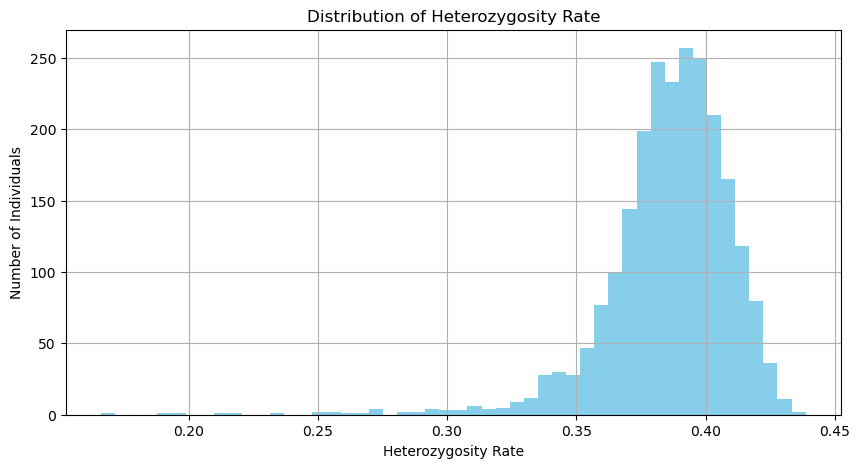

Number of outliers: 32
Outliers: col_label            chr_1_pos_88671  chr_1_pos_114576  chr_1_pos_115699  chr_1_pos_155552  chr_1_pos_175528  chr_1_pos_181280  chr_1_pos_201670  chr_1_pos_261558  chr_1_pos_277357  chr_1_pos_298436  ...  chr_5_pos_99141416  chr_5_pos_99172858  chr_5_pos_99213046  chr_5_pos_99233297  chr_5_pos_99426456  chr_5_pos_99471982  chr_5_pos_99610295  chr_5_pos_99766772  chr_5_pos_99812870  heterozygosity
MP_5_FP_8_SEX_F                    2                 2                 2                 1                 2                 2                 2                 2                 2                 0  ...                   2                   0                   1                   1                   1                   0                   1                   1                   2        0.272057
MP_5_FP_8_SEX_F                    2                 2                 2                 1                 2                 2                 2                 2     

In [27]:

heterozygosity_check_df = genotypes_df_sub.copy()
heterozygosity_check_df.drop(columns=['Q', 'B'], inplace=True)
# Heterozygosity rate = (# heterozygous SNPs) / (# non-missing SNPs)
heterozygosity_rate = (heterozygosity_check_df == 1).sum(axis=1) / heterozygosity_check_df.notna().sum(axis=1)

# Add to original dataframe
heterozygosity_check_df['heterozygosity'] = heterozygosity_rate

# Plot
plt.figure(figsize=(10, 5))
plt.hist(heterozygosity_rate, bins=50, color='skyblue')
plt.xlabel('Heterozygosity Rate')
plt.ylabel('Number of Individuals')
plt.title('Distribution of Heterozygosity Rate')
plt.grid(True)
plt.show()

# Detect outliers (e.g., 3 standard deviations from mean)
mean_hr = heterozygosity_rate.mean()
std_hr = heterozygosity_rate.std()

outliers = heterozygosity_check_df[(heterozygosity_check_df['heterozygosity'] < mean_hr - 3*std_hr) |
                                    (heterozygosity_check_df['heterozygosity'] > mean_hr + 3*std_hr)]
print("Number of outliers:", len(outliers))
print("Outliers:", outliers)
outlier_samples = list(outliers.index)
print("Outliers:", outlier_samples)


### 32 Outlier samples detected with low Heterozygosity 

In [29]:

filtered_genotype_df_sub = genotypes_df_sub[(heterozygosity_check_df['heterozygosity'] >= mean_hr - 3*std_hr) &
                                    (heterozygosity_check_df['heterozygosity'] <= mean_hr + 3*std_hr)]

filtered_genotype_df_sub

col_label,chr_1_pos_88671,chr_1_pos_114576,chr_1_pos_115699,chr_1_pos_155552,chr_1_pos_175528,chr_1_pos_181280,chr_1_pos_201670,chr_1_pos_261558,chr_1_pos_277357,chr_1_pos_298436,...,chr_5_pos_99172858,chr_5_pos_99213046,chr_5_pos_99233297,chr_5_pos_99426456,chr_5_pos_99471982,chr_5_pos_99610295,chr_5_pos_99766772,chr_5_pos_99812870,Q,B
MP_0_FP_0_SEX_M,2,2,1,1,2,1,2,1,1,0,...,0,2,2,2,0,1,1,2,64.22,0
MP_0_FP_0_SEX_M,1,1,0,1,1,1,1,1,2,0,...,0,1,2,2,0,1,0,1,88.88,1
MP_0_FP_0_SEX_M,1,2,0,1,1,1,2,0,0,0,...,0,2,0,1,0,1,1,2,64.02,0
MP_0_FP_0_SEX_M,2,2,0,0,1,0,2,0,1,0,...,0,1,2,2,0,1,1,2,68.51,0
MP_0_FP_0_SEX_M,2,1,1,1,2,2,1,2,2,0,...,0,0,2,2,0,0,0,2,61.08,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MP_1150_FP_1125_SEX_M,1,1,1,2,2,2,1,2,2,0,...,0,1,1,1,0,1,1,2,65.93,0
MP_1150_FP_1125_SEX_F,2,2,0,0,1,0,2,0,1,0,...,0,1,2,2,0,0,0,2,69.36,0
MP_1150_FP_1125_SEX_M,2,2,0,0,1,0,2,0,1,0,...,0,1,1,1,0,1,1,2,74.89,0
MP_1150_FP_1125_SEX_F,2,2,0,0,1,0,2,0,1,0,...,0,2,2,2,0,1,1,2,75.94,0


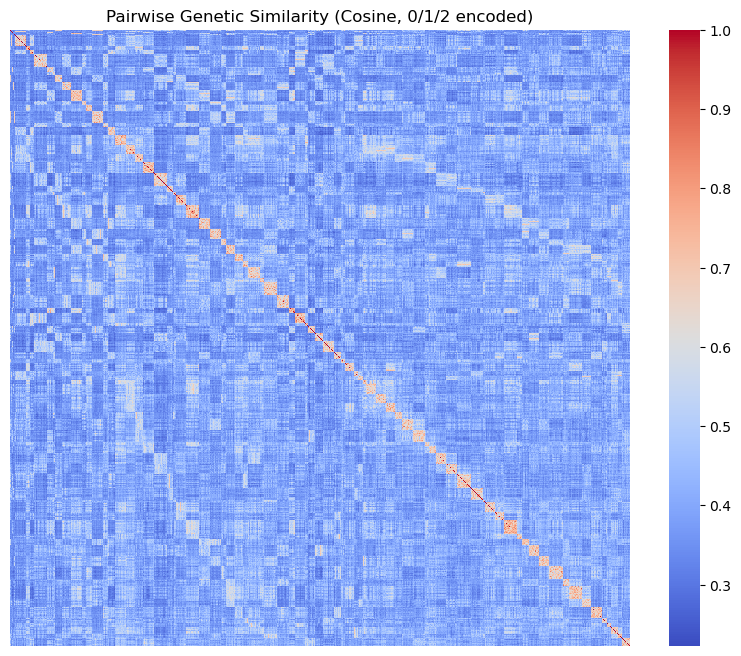

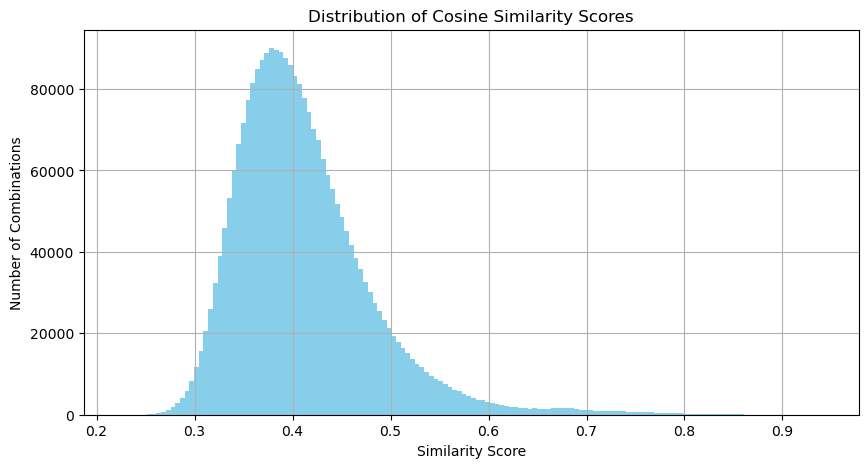

Highly similar individuals (possible duplicates/relatives): >95%
Number of highly similar pairs: 0


In [30]:
genotypes_df_sub_allele = filtered_genotype_df_sub.copy()
genotypes_df_sub_allele.drop(columns=['Q', 'B'], inplace=True)



# Assume df is your DataFrame with:
# - One row per individual
# - One column per SNP
# - Genotypes encoded as 0, 1, 2 (after dropping ID column)

genotype_matrix = genotypes_df_sub_allele.to_numpy()

# Normalize genotype values if needed (mean-center)
# For correlation-based similarity
norm_genotypes = (genotype_matrix - genotype_matrix.mean(axis=1, keepdims=True))

# Compute pairwise cosine similarity (can also use 1 - normalized euclidean or Hamming)
similarity_matrix = cosine_similarity(norm_genotypes)

# Create a DataFrame for easy viewing
sim_df = pd.DataFrame(similarity_matrix, index=genotypes_df_sub_allele.index, columns=genotypes_df_sub_allele.index)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(sim_df, cmap='coolwarm', xticklabels=False, yticklabels=False)
plt.title("Pairwise Genetic Similarity (Cosine, 0/1/2 encoded)")
plt.show()

# Identify pairs with very high similarity (e.g., > 0.98)
threshold = 0.95
high_sim_pairs = []
all_sims = []
ids = genotypes_df_sub_allele.index.values
for i in range(len(ids)):
    for j in range(i+1, len(ids)):
        sim = similarity_matrix[i, j]
        all_sims.append(sim)
        if sim > threshold:
            high_sim_pairs.append((ids[i], ids[j], sim))


plt.figure(figsize=(10, 5))
plt.hist(all_sims, bins=150, color='skyblue')
plt.xlabel('Similarity Score')
plt.ylabel('Number of Combinations')
plt.title('Distribution of Cosine Similarity Scores')
plt.grid(True)
plt.show()

print("Highly similar individuals (possible duplicates/relatives): >95%")
for pair in high_sim_pairs:
    print(pair)
print("Number of highly similar pairs:", len(high_sim_pairs))

### We observe a lot of individuals with > 0.5 similarity but this is possible as our population is all related (5 generations): Sign of Kinship/Ancestry
### We have no samples with more than 95% similarity -> NO duplicates

# SNP Level QC checks

### Minor Allele frequency (MAF)

In [34]:
genotypes_df_maf = filtered_genotype_df_sub.copy()
genotypes_df_maf.drop(columns=['Q', 'B'], inplace=True)

In [35]:
def calculate_maf(genotype_data):
    # Calculate the frequency of each genotype (0, 1, 2) for each SNP
    #allele_counts = genotype_data.apply(pd.Series.value_counts, axis=0).fillna(0)
    #
    ## MAF = min(frequency of minor allele (either 0 or 2)) / total
    #maf = allele_counts.apply(lambda x: min(x[0], x[2]) / sum(x), axis=0)
    #minor_allele_counts = np.sum(genotype_matrix, axis=0)

    num_individuals = genotype_data.shape[0]
    
    # Sum the values for each SNP column (this gives us the number of minor alleles per SNP)
    minor_allele_counts = genotype_data.sum()
    
    # Calculate MAF (minor alleles count / (2 * number of individuals))
    maf = minor_allele_counts / (2 * num_individuals)
    
    return maf

maf_values = calculate_maf(genotypes_df_maf)
low_maf_threshold = 0.01
filtered_snps = maf_values[maf_values > low_maf_threshold].index


In [36]:
filtered_snps = filtered_snps.append(filtered_genotype_df_sub[['Q','B']].columns)
#filtered_genotype_df_sub[['Q','B']].columns
filtered_snps

Index(['chr_1_pos_88671', 'chr_1_pos_114576', 'chr_1_pos_115699', 'chr_1_pos_155552', 'chr_1_pos_175528', 'chr_1_pos_181280', 'chr_1_pos_201670', 'chr_1_pos_261558', 'chr_1_pos_277357', 'chr_1_pos_309705',
       ...
       'chr_5_pos_99117225', 'chr_5_pos_99141416', 'chr_5_pos_99213046', 'chr_5_pos_99233297', 'chr_5_pos_99426456', 'chr_5_pos_99610295', 'chr_5_pos_99766772', 'chr_5_pos_99812870', 'Q', 'B'], dtype='object', name='col_label', length=9883)

In [37]:
print(len(maf_values))
print(len(filtered_snps))
print(1 - len(filtered_snps)/len(maf_values))
print(len(maf_values) -len(filtered_snps))

10031
9883
0.014754261788455736
148


### 150 SNPs have less than 1% MAF
#### These consist of 1.4% of the SNPs in the dataset

### Monomorphic SNPs

In [40]:
maf_filtered_snps = filtered_genotype_df_sub[filtered_snps]
genotypes_df_mono = maf_filtered_snps.copy()
#genotypes_df_mono.drop(columns=['Q', 'B'], inplace=True)

In [41]:

# Convert to DataFrame
genotype_df = pd.DataFrame(genotypes_df_mono)

# Identify monomorphic SNPs (those with the same value across all rows)
monomorphic_snps = genotype_df.nunique() == 1

# Filter out monomorphic SNPs
filtered_genotype_df = genotype_df.loc[:, ~monomorphic_snps]

# Print the filtered DataFrame
print("Filtered Genotype DataFrame (without monomorphic SNPs):")
print(filtered_genotype_df)


Filtered Genotype DataFrame (without monomorphic SNPs):
col_label              chr_1_pos_88671  chr_1_pos_114576  chr_1_pos_115699  chr_1_pos_155552  chr_1_pos_175528  chr_1_pos_181280  chr_1_pos_201670  chr_1_pos_261558  chr_1_pos_277357  chr_1_pos_309705  ...  chr_5_pos_99117225  chr_5_pos_99141416  chr_5_pos_99213046  chr_5_pos_99233297  chr_5_pos_99426456  chr_5_pos_99610295  chr_5_pos_99766772  chr_5_pos_99812870      Q  B
MP_0_FP_0_SEX_M                      2                 2                 1                 1                 2                 1                 2                 1                 1                 2  ...                   1                   0                   2                   2                   2                   1                   1                   2  64.22  0
MP_0_FP_0_SEX_M                      1                 1                 0                 1                 1                 1                 1                 1                 2          

In [42]:
filtered_genotype_df['Q'].describe()

count    2294.000000
mean       68.683976
std        10.050291
min        35.000000
25%        61.975000
50%        68.720000
75%        75.427500
max       100.750000
Name: Q, dtype: float64

In [43]:
filtered_genotype_df["B"]  # binary target (0/1)

MP_0_FP_0_SEX_M          0
MP_0_FP_0_SEX_M          1
MP_0_FP_0_SEX_M          0
MP_0_FP_0_SEX_M          0
MP_0_FP_0_SEX_M          0
                        ..
MP_1150_FP_1125_SEX_M    0
MP_1150_FP_1125_SEX_F    0
MP_1150_FP_1125_SEX_M    0
MP_1150_FP_1125_SEX_F    0
MP_1150_FP_1125_SEX_M    0
Name: B, Length: 2294, dtype: int64

## Metrics

In [73]:
filtered_genotype_df.to_csv('processed_raw_data.csv', header=True)

In [74]:
! pip install rpy2


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


##  Random Forest Analysis on Genotype Data


===== Starting Random Forest Analysis =====

--- Training Random Forest model ---
Random Forest performance:
  Train R²: 0.9050
  Test R²: 0.3036
  Train MSE: 9.7055
  Test MSE: 66.8035


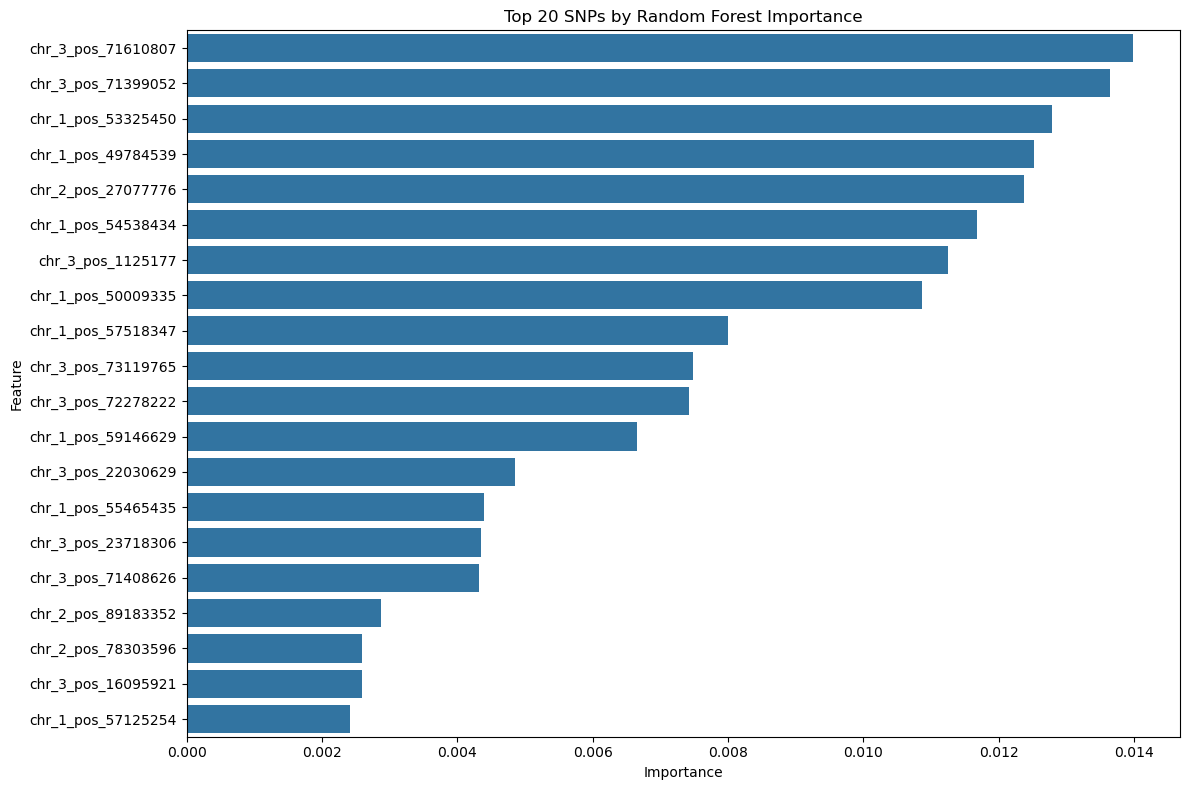


--- Optimizing model with GridSearchCV ---
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'max_depth': None, 'max_features': 0.3, 'min_samples_split': 10, 'n_estimators': 200}
Best CV score: 0.3325

Optimized Random Forest performance:
  Train R²: 0.8498
  Test R²: 0.2953
Features with Importance > 0: 9169
                 Feature    Importance
931   chr_1_pos_50009335  1.170985e-02
2539  chr_2_pos_27077776  1.146175e-02
5337  chr_3_pos_71399052  8.494362e-03
1016  chr_1_pos_54538434  8.323446e-03
989   chr_1_pos_53325450  7.547679e-03
...                  ...           ...
6057   chr_4_pos_6455852  2.986235e-07
5325  chr_3_pos_71004089  2.985035e-07
6606  chr_4_pos_31624217  2.773612e-07
3158  chr_2_pos_58036266  2.700093e-07
9202  chr_5_pos_70356694  2.357482e-07

[9169 rows x 2 columns]


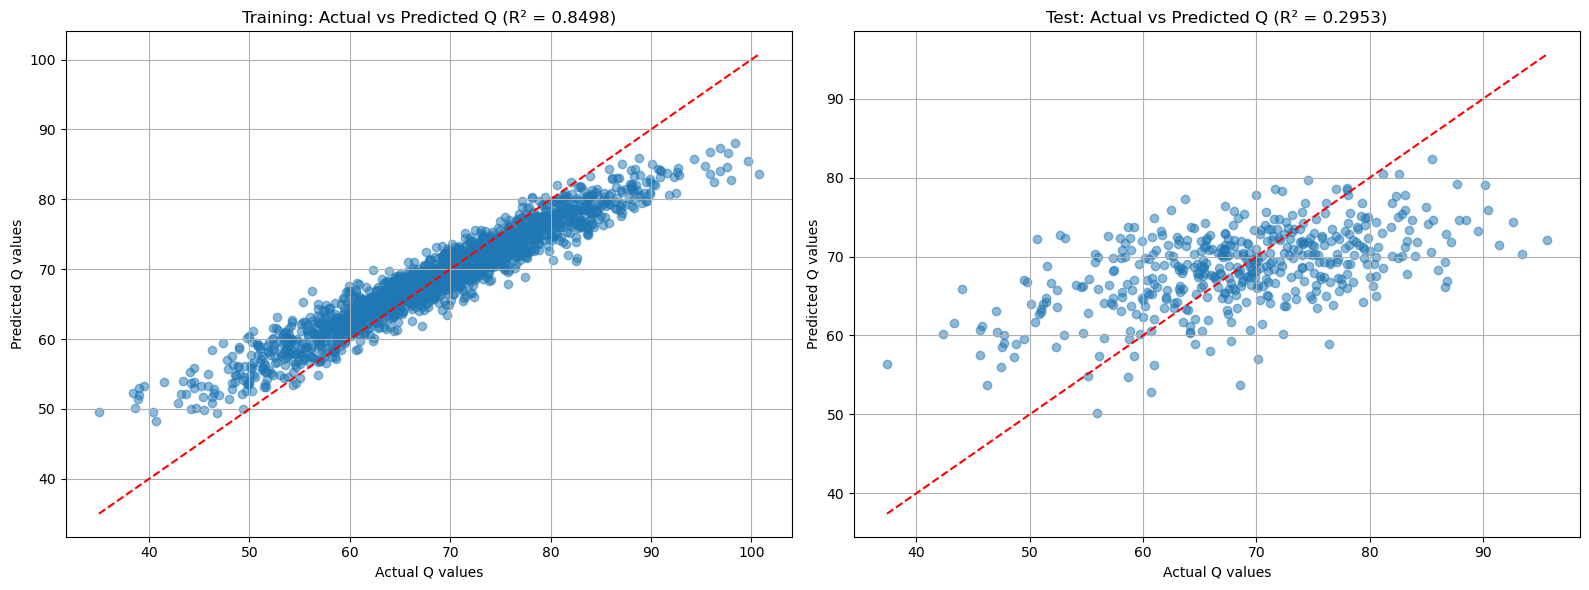

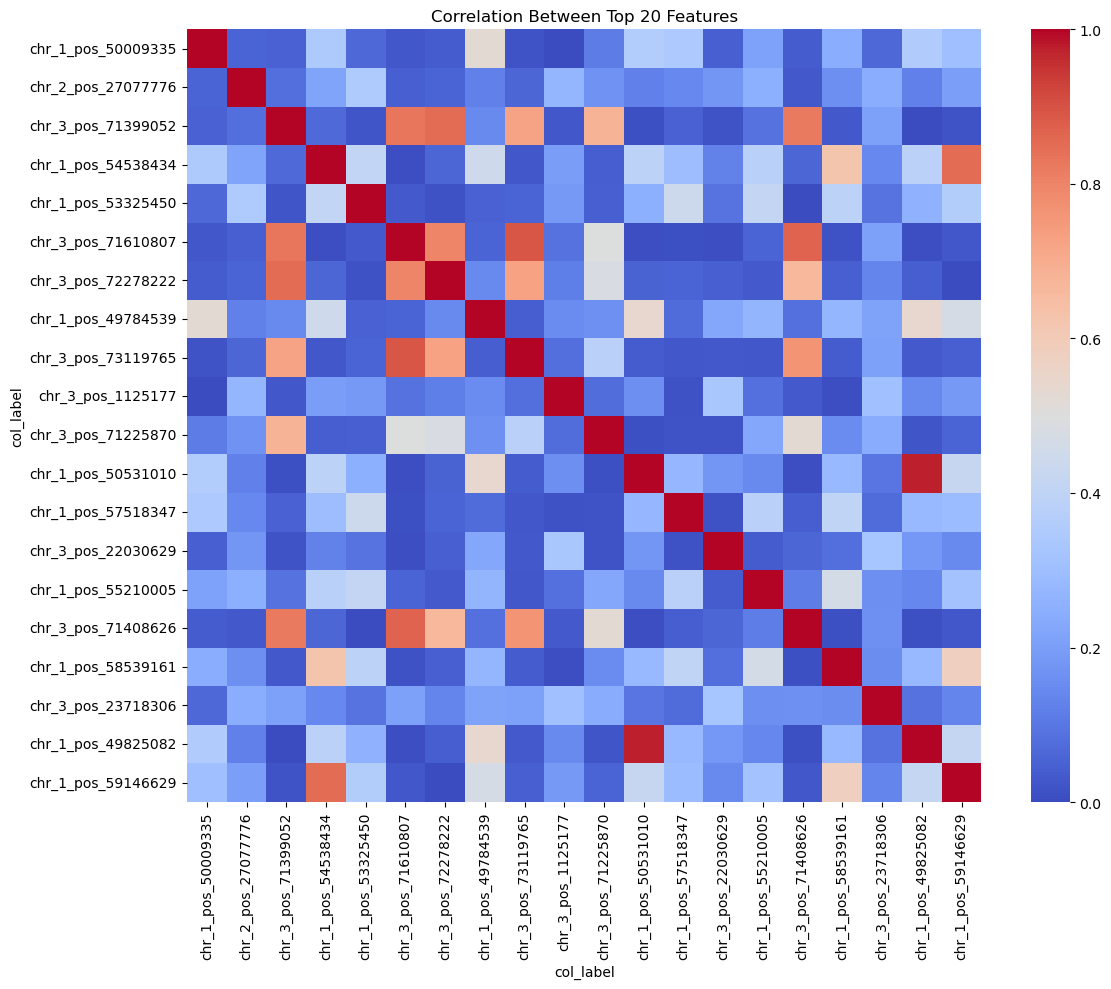


--- Generating Partial Dependence Plots ---
Top 3 features: ['chr_1_pos_50009335', 'chr_2_pos_27077776', 'chr_3_pos_71399052']


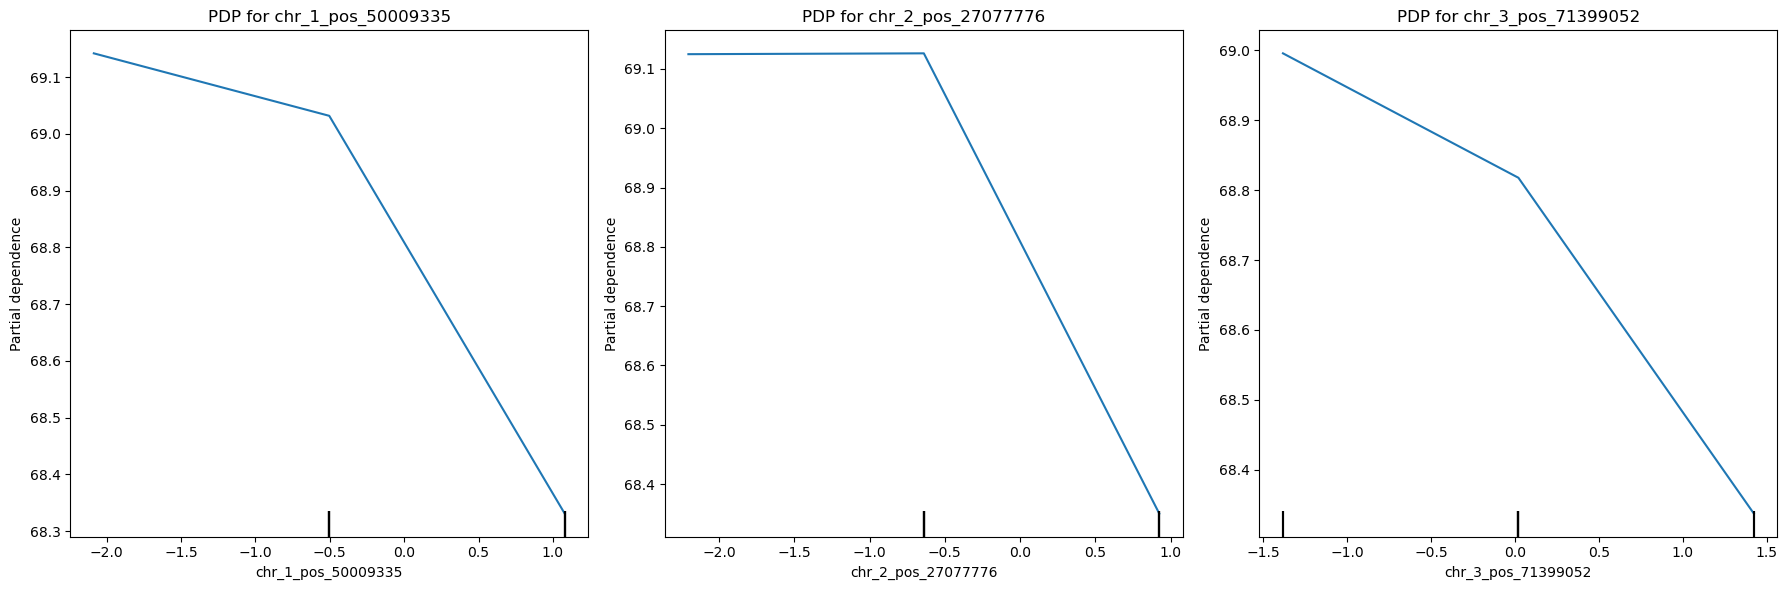

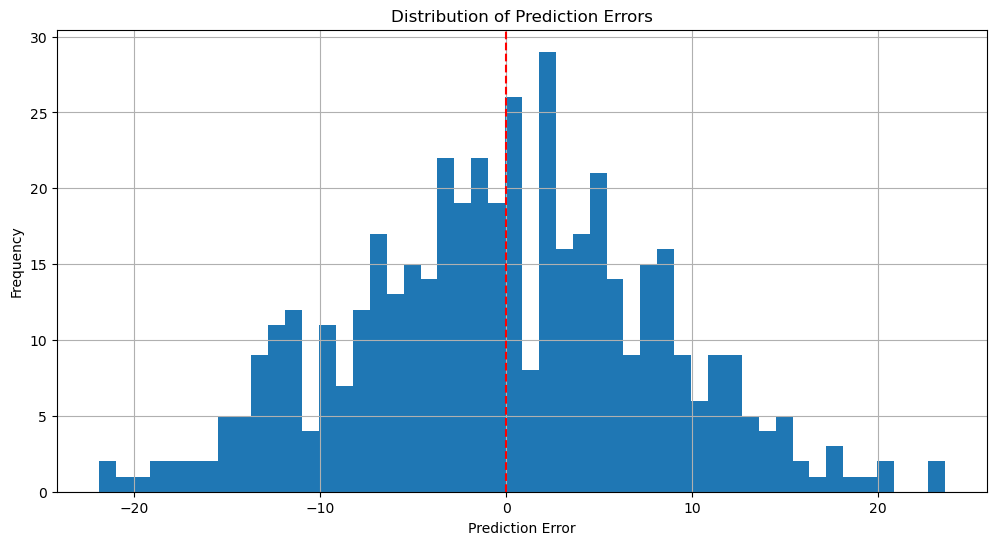

In [78]:
def run_random_forest_analysis(filtered_genotype_df):
    """
    Perform Random Forest analysis on genetic data
    
    Parameters:
    filtered_genotype_df: DataFrame containing genotype data and phenotypes (Q, B)
    
    Returns:
    Dictionary containing model, predictions, and feature importance
    """
    print("\n===== Starting Random Forest Analysis =====")
    
    # Prepare data - extract phenotype Q and genotypes
    X = filtered_genotype_df.drop(columns=['Q', 'B'])
    y_q = filtered_genotype_df['Q']
    
    # Handle missing values
    X_imputed = X.fillna(X.mean())
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_imputed, y_q, test_size=0.2, random_state=42
    )
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Convert to DataFrames to keep column names
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
    
    # First run a basic model
    print("\n--- Training Random Forest model ---")
    rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_train_scaled_df, y_train)
    
    # Make predictions
    y_train_pred = rf.predict(X_train_scaled_df)
    y_test_pred = rf.predict(X_test_scaled_df)
    
    # Calculate performance metrics
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    
    print(f"Random Forest performance:")
    print(f"  Train R²: {train_r2:.4f}")
    print(f"  Test R²: {test_r2:.4f}")
    print(f"  Train MSE: {train_mse:.4f}")
    print(f"  Test MSE: {test_mse:.4f}")
    
    # Calculate feature importance
    importance_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': rf.feature_importances_
    }).sort_values(by='Importance', ascending=False)
    
    # Visualize feature importance
    plt.figure(figsize=(12, 8))
    top_20_features = importance_df.head(20)
    sns.barplot(x='Importance', y='Feature', data=top_20_features)
    plt.title('Top 20 SNPs by Random Forest Importance')
    plt.tight_layout()
    plt.show()
    
    # Optimize hyperparameters with GridSearchCV
    print("\n--- Optimizing model with GridSearchCV ---")
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_features': ['sqrt', 'log2', 0.3],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    }
    
    # Use a smaller subset for grid search to save time
    grid_search = GridSearchCV(
        RandomForestRegressor(random_state=42, n_jobs=-1),
        param_grid=param_grid,
        cv=5,
        scoring='r2',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train_scaled_df, y_train)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV score: {grid_search.best_score_:.4f}")
    
    # Train final model with best parameters
    best_rf = grid_search.best_estimator_
    best_rf.fit(X_train_scaled_df, y_train)
    
    # Make predictions with optimized model
    y_train_pred_best = best_rf.predict(X_train_scaled_df)
    y_test_pred_best = best_rf.predict(X_test_scaled_df)
    
    # Calculate performance metrics for optimized model
    best_train_r2 = r2_score(y_train, y_train_pred_best)
    best_test_r2 = r2_score(y_test, y_test_pred_best)
    
    print(f"\nOptimized Random Forest performance:")
    print(f"  Train R²: {best_train_r2:.4f}")
    print(f"  Test R²: {best_test_r2:.4f}")
    
    # Get feature importance from optimized model
    best_importance_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': best_rf.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    positive_importance_df = best_importance_df[best_importance_df['Importance'] > 0]

    print(f"Features with Importance > 0: {len(positive_importance_df)}")
    print(positive_importance_df)
    
    # Visualize scatter plots of actual vs predicted values
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Training data
    ax1.scatter(y_train, y_train_pred_best, alpha=0.5)
    ax1.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
    ax1.set_xlabel('Actual Q values')
    ax1.set_ylabel('Predicted Q values')
    ax1.set_title(f'Training: Actual vs Predicted Q (R² = {best_train_r2:.4f})')
    ax1.grid(True)
    
    # Test data
    ax2.scatter(y_test, y_test_pred_best, alpha=0.5)
    ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    ax2.set_xlabel('Actual Q values')
    ax2.set_ylabel('Predicted Q values')
    ax2.set_title(f'Test: Actual vs Predicted Q (R² = {best_test_r2:.4f})')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Analyze top features
    top_features = best_importance_df.head(100)['Feature'].tolist()
    
    # Feature clusters visualization (correlation between top features)
    top_feature_data = X_imputed[top_features[:20]]  # Use top 20 for visualization
    corr_matrix = top_feature_data.corr().abs()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=0, vmax=1)
    plt.title('Correlation Between Top 20 Features')
    plt.tight_layout()
    plt.show()
    
    # Partial Dependence Plots for top 3 features
    print("\n--- Generating Partial Dependence Plots ---")
    
    # Create individual partial dependence plots for top 3 features
    from sklearn.inspection import PartialDependenceDisplay
    
    top_3_features = best_importance_df.head(3)['Feature'].tolist()
    print(f"Top 3 features: {top_3_features}")
    
    # Create PDPs
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    for i, feature in enumerate(top_3_features):
        feature_idx = list(X_train.columns).index(feature)
        PartialDependenceDisplay.from_estimator(
            best_rf, 
            X_train_scaled_df, 
            [feature], 
            ax=axes[i]
        )
        axes[i].set_title(f'PDP for {feature}')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Partial Dependence')
        axes[i].set_title(f'PDP for {feature}')
        axes[i].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Analyze prediction errors
    test_errors = y_test - y_test_pred_best
    
    plt.figure(figsize=(12, 6))
    plt.hist(test_errors, bins=50)
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')
    plt.title('Distribution of Prediction Errors')
    plt.grid(True)
    plt.axvline(x=0, color='r', linestyle='--')
    plt.show()
    
    # Return results
    return {
        'model': best_rf,
        'predictions': {
            'y_train_pred': y_train_pred_best,
            'y_test_pred': y_test_pred_best
        },
        'metrics': {
            'train_r2': best_train_r2,
            'test_r2': best_test_r2
        },
        'feature_importance': best_importance_df,
        'top_features': top_features,
        'X_train_scaled_df': X_train_scaled_df,  # <-- ADD
        'X_test_scaled_df': X_test_scaled_df,    # <-- ADD
        'y_train': y_train,                      # <-- ADD
        'y_test': y_test                         # <-- ADD
}
    
    # Summary of results
    print("\n===== Results Summary =====")
    print(f"Number of input features: {X.shape[1]}")
    print(f"Training samples: {X_train.shape[0]}")
    print(f"Test samples: {X_test.shape[0]}")
    print(f"Best model R² on test data: {best_test_r2:.4f}")
    print(f"Top 10 important SNPs:")
    for i, (feature, importance) in enumerate(zip(best_importance_df['Feature'].head(10), 
                                              best_importance_df['Importance'].head(10))):
        print(f"  {i+1}. {feature}: {importance:.6f}")
    
    return results


rf_results = run_random_forest_analysis(filtered_genotype_df)

##  Feature Selection by Importance Threshold

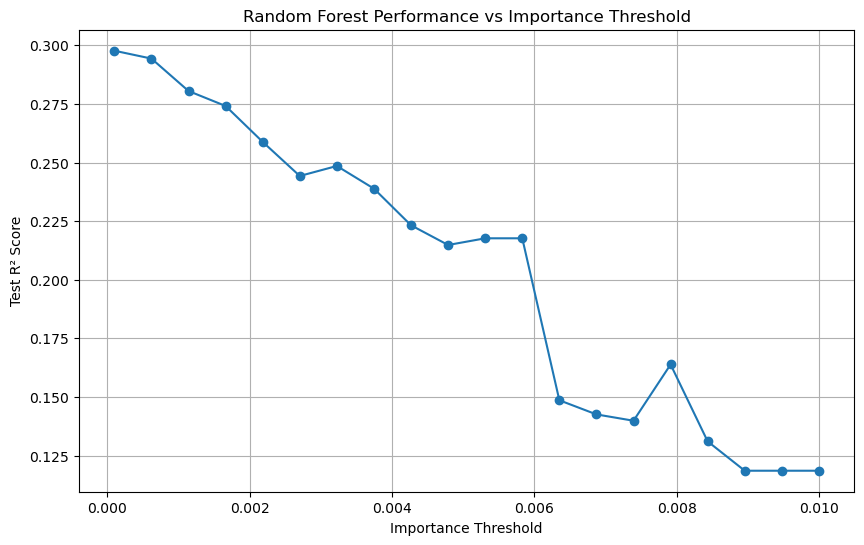

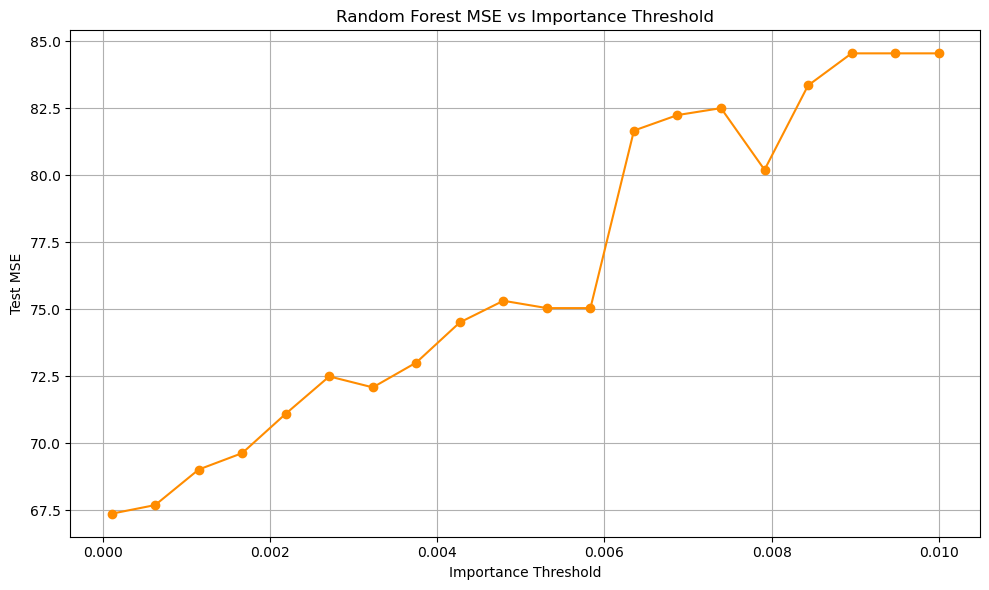


Best threshold: 0.0001
Number of selected features: 2843
Best Test R²: 0.2977


In [80]:
# --- Find best importance threshold to select features and retrain Random Forest ---

# Extract feature importances
best_importance_df = rf_results['feature_importance']

# Define a range of importance thresholds to test
thresholds = np.linspace(0.0001, 0.01, 20)

# Store performance for each threshold
threshold_results = []

# Prepare data
X_full = filtered_genotype_df.drop(columns=['Q', 'B'])
y_full = filtered_genotype_df['Q']
X_full_imputed = X_full.fillna(X_full.mean())

# Split again to match earlier
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X_full_imputed, y_full, test_size=0.2, random_state=42
)

# Standardize
scaler = StandardScaler()
X_train_scaled_full = pd.DataFrame(scaler.fit_transform(X_train_full), columns=X_train_full.columns, index=X_train_full.index)
X_test_scaled_full = pd.DataFrame(scaler.transform(X_test_full), columns=X_test_full.columns, index=X_test_full.index)

for thresh in thresholds:
    selected_features = best_importance_df[best_importance_df['Importance'] > thresh]['Feature'].tolist()
    
    if len(selected_features) == 0:
        continue  # Skip if no features are selected
    
    # Train on selected features
    X_train_selected = X_train_scaled_full[selected_features]
    X_test_selected = X_test_scaled_full[selected_features]
    
    model = RandomForestRegressor(
        n_estimators=200,
        max_depth=30,
        min_samples_split=10,
        max_features=0.3,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train_selected, y_train_full)
    
    y_test_pred = model.predict(X_test_selected)
    test_r2 = r2_score(y_test_full, y_test_pred)
    test_mse = mean_squared_error(y_test_full, y_test_pred)
    
    threshold_results.append((thresh, len(selected_features), test_r2, test_mse))

# --- Summarize results ---
threshold_df = pd.DataFrame(threshold_results, columns=['Threshold', 'NumFeatures', 'TestR2', 'TestMSE'])

# Plot threshold vs Test R²
plt.figure(figsize=(10,6))
plt.plot(threshold_df['Threshold'], threshold_df['TestR2'], marker='o')
plt.xlabel('Importance Threshold')
plt.ylabel('Test R² Score')
plt.title('Random Forest Performance vs Importance Threshold')
plt.grid(True)
plt.show()

# Plot 2: Threshold vs Test MSE
plt.figure(figsize=(10, 6))
plt.plot(threshold_df['Threshold'], threshold_df['TestMSE'], marker='o', color='darkorange')
plt.xlabel('Importance Threshold')
plt.ylabel('Test MSE')
plt.title('Random Forest MSE vs Importance Threshold')
plt.grid(True)
plt.tight_layout()
plt.show()

# Find the best threshold
best_row = threshold_df.loc[threshold_df['TestR2'].idxmax()]
print(f"\nBest threshold: {best_row['Threshold']:.4f}")
print(f"Number of selected features: {int(best_row['NumFeatures'])}")
print(f"Best Test R²: {best_row['TestR2']:.4f}")


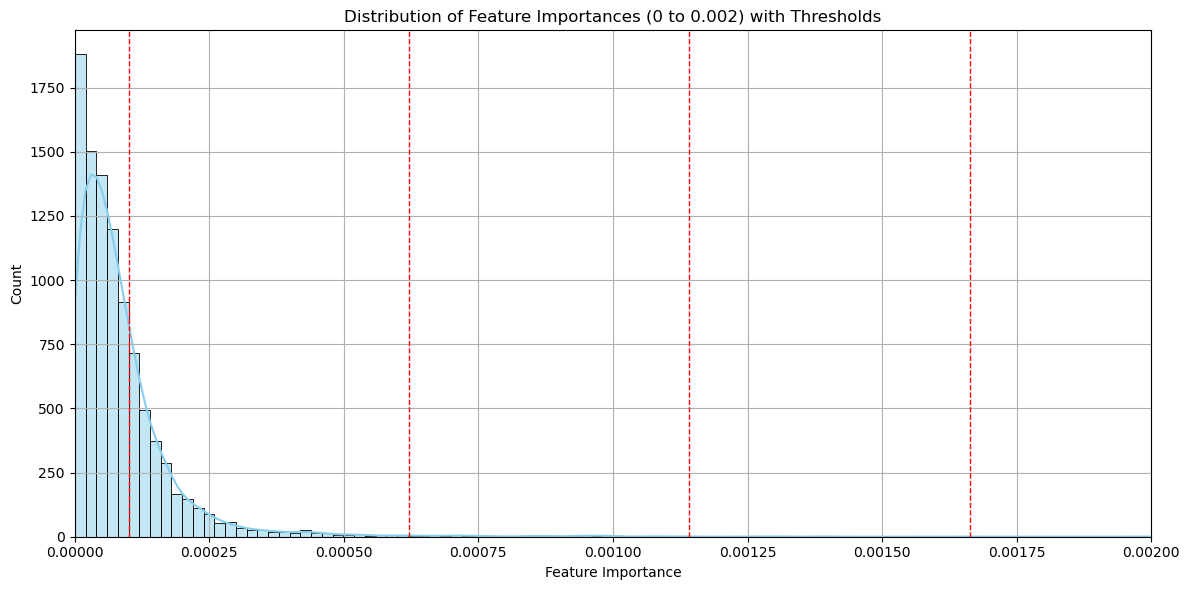

In [81]:
# --- Plot the distribution of feature importances and thresholds (0 to 0.002) ---

# Extract all importances
all_importances = best_importance_df['Importance'].values

# Filter importances within the desired range
filtered_importances = all_importances[all_importances <= 0.002]
filtered_thresholds = [t for t in thresholds if 0 <= t <= 0.002]

plt.figure(figsize=(12, 6))

# Plot histogram of filtered feature importances
sns.histplot(filtered_importances, bins=100, kde=True, color='skyblue')

# Overlay the filtered thresholds
for thresh in filtered_thresholds:
    plt.axvline(x=thresh, color='red', linestyle='--', linewidth=1)

plt.xlim(0, 0.002)
plt.xlabel('Feature Importance')
plt.ylabel('Count')
plt.title('Distribution of Feature Importances (0 to 0.002) with Thresholds')
plt.grid(True)
plt.tight_layout()
plt.show()


##  Final Model with Feature Importance Threshold = 0.00025

Number of features selected at threshold 0.00025: 497

Random Forest with threshold 0.00025:
  Train R²: 0.7589
  Test R²: 0.3063


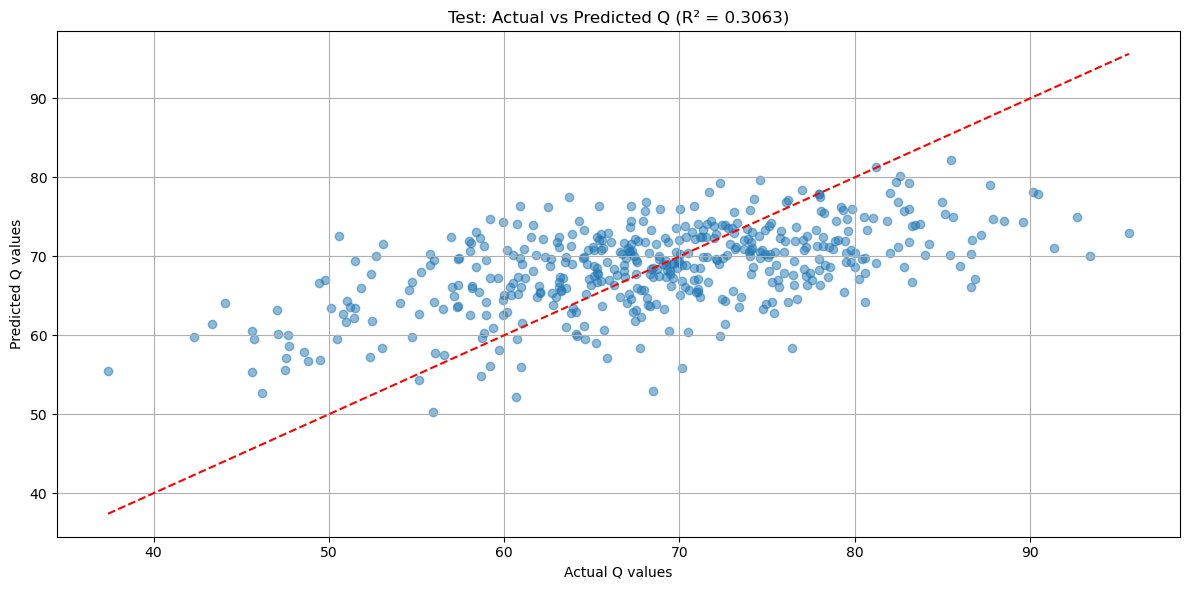

In [83]:


# Set threshold
threshold = 0.00025

# Select features above the threshold
selected_features = best_importance_df[best_importance_df['Importance'] > threshold]['Feature'].tolist()
print(f"Number of features selected at threshold {threshold}: {len(selected_features)}")

# Prepare data
X = filtered_genotype_df[selected_features]
y = filtered_genotype_df["Q"]

# Handle missing values
X_imputed = X.fillna(X.mean())

# Split and scale
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest with best parameters from GridSearch
rf_thresh = RandomForestRegressor(
    n_estimators=200, 
    max_depth=25, 
    max_features=0.3, 
    min_samples_split=15,
    random_state=42, 
    n_jobs=-1
)
rf_thresh.fit(X_train_scaled, y_train)

# Predict
y_train_pred = rf_thresh.predict(X_train_scaled)
y_test_pred = rf_thresh.predict(X_test_scaled)

# Evaluate
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
print(f"\nRandom Forest with threshold {threshold}:")
print(f"  Train R²: {train_r2:.4f}")
print(f"  Test R²: {test_r2:.4f}")

# Plot predictions
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Q values")
plt.ylabel("Predicted Q values")
plt.title(f"Test: Actual vs Predicted Q (R² = {test_r2:.4f})")
plt.grid(True)
plt.tight_layout()
plt.show()


## Threshold Tuning: Performance vs Number of Selected Features

Objective
To systematically evaluate how different feature importance thresholds impact the performance, complexity, and training time of the Random Forest model.

This section extracts the model's feature importances and tests various thresholds to:
- Reduce dimensionality
- Monitor **R²** and **MSE** trends
- Track training time
- Visualize how model performance scales with number of features

Plots include:
- R² vs Threshold
- MSE vs Threshold
- Combined plot of R², Test MSE, and Training Time vs Number of Selected SNPs

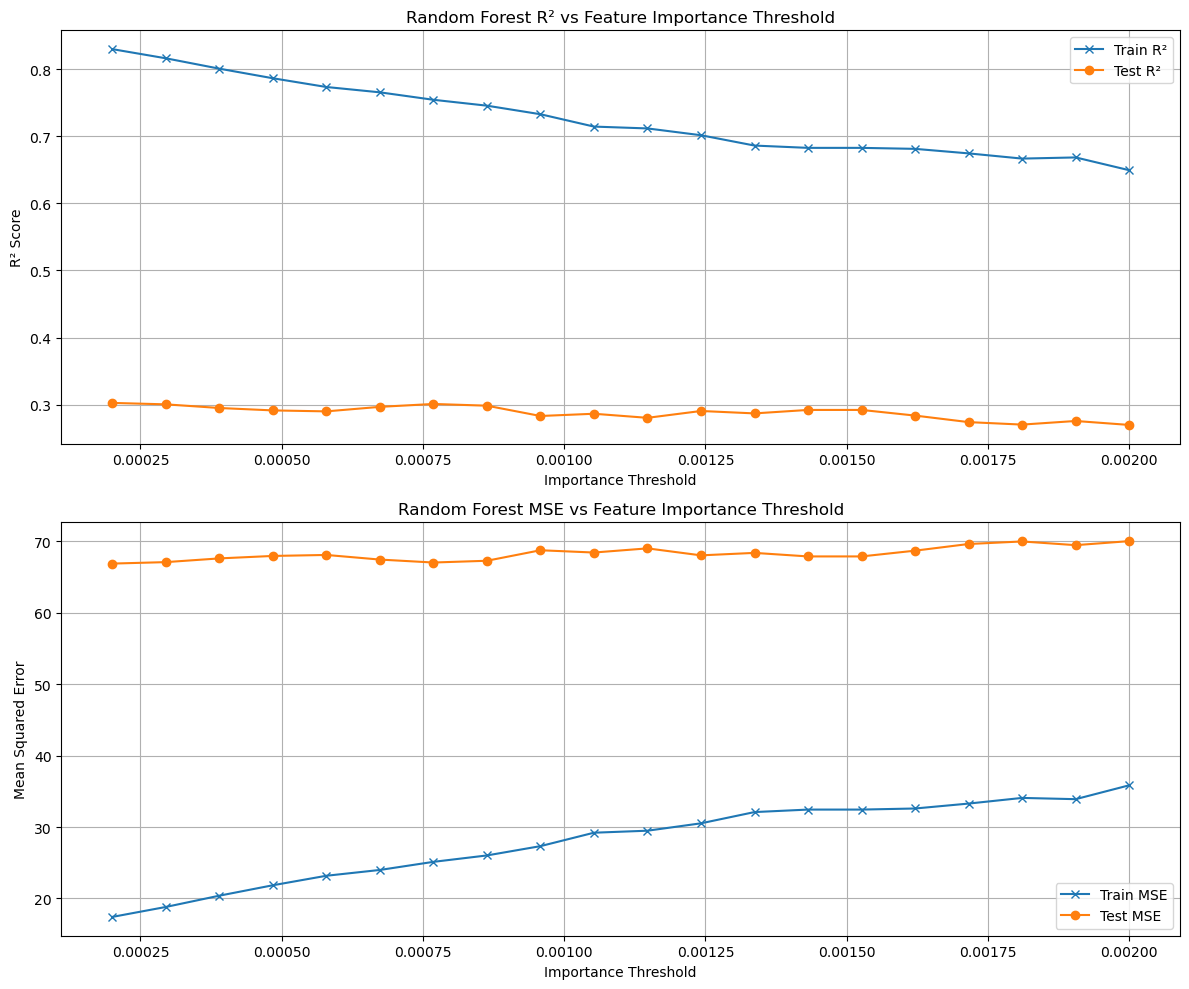

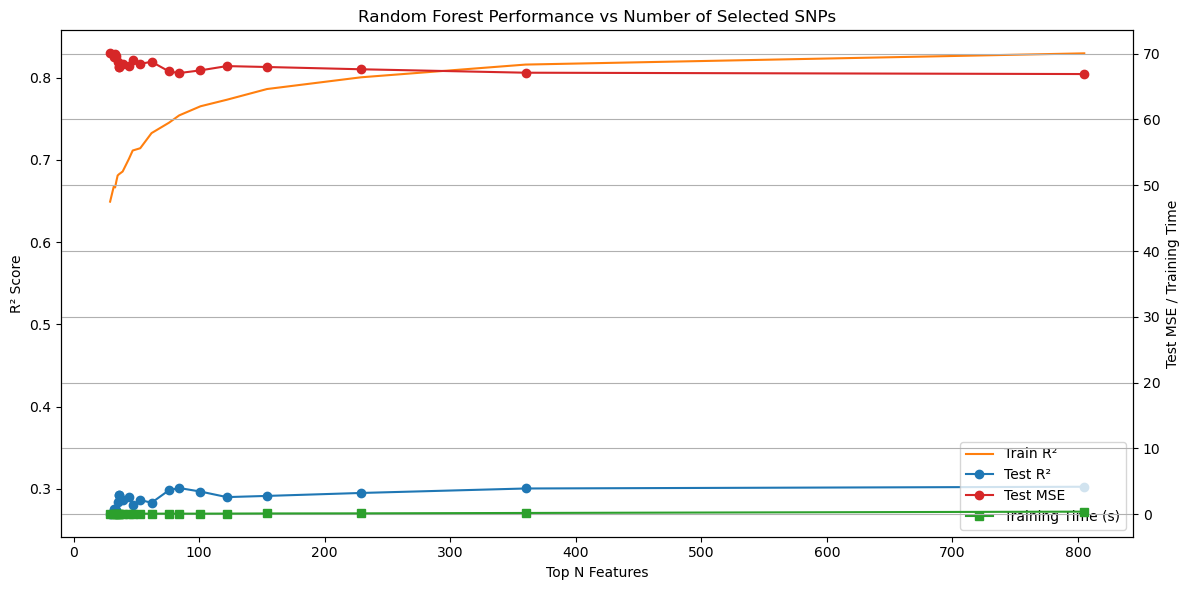

In [137]:


# Extract needed variables from rf_results
best_importance_df = rf_results['feature_importance']
X_train_scaled_df = rf_results['X_train_scaled_df']
X_test_scaled_df = rf_results['X_test_scaled_df']
y_train = rf_results['y_train']
y_test = rf_results['y_test']

thresholds = np.linspace(0.0002, 0.002, 20)
results = []

for thresh in thresholds:
    selected = best_importance_df[best_importance_df['Importance'] >= thresh]['Feature'].tolist()
    
    if len(selected) == 0:
        continue  # Skip thresholds where no features are selected
    
    X_sel_train = X_train_scaled_df[selected]
    X_sel_test = X_test_scaled_df[selected]

    rf = RandomForestRegressor(
        n_estimators=200,
        max_depth=30,
        max_features=0.3,
        min_samples_split=10,
        random_state=42,
        n_jobs=-1
    )
    start = time.time()
    rf.fit(X_sel_train, y_train)
    training_time = time.time() - start
    y_train_pred = rf.predict(X_sel_train)
    y_test_pred = rf.predict(X_sel_test)

    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    results.append({
        'Threshold': thresh,
        'Features': len(selected),
        'Train R2': train_r2,
        'Test R2': test_r2,
        'Train MSE': train_mse,
        'Test MSE': test_mse,
        'Training Time': training_time
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Plotting R² and MSE
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# R² plot
axes[0].plot(results_df['Threshold'], results_df['Train R2'], label='Train R²', marker='x')
axes[0].plot(results_df['Threshold'], results_df['Test R2'], label='Test R²', marker='o')
axes[0].set_title('Random Forest R² vs Feature Importance Threshold')
axes[0].set_xlabel('Importance Threshold')
axes[0].set_ylabel('R² Score')
axes[0].legend()
axes[0].grid(True)

# MSE plot
axes[1].plot(results_df['Threshold'], results_df['Train MSE'], label='Train MSE', marker='x')
axes[1].plot(results_df['Threshold'], results_df['Test MSE'], label='Test MSE', marker='o')
axes[1].set_title('Random Forest MSE vs Feature Importance Threshold')
axes[1].set_xlabel('Importance Threshold')
axes[1].set_ylabel('Mean Squared Error')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

fig, ax1 = plt.subplots(figsize=(12, 6))

# Left y-axis
color_r2_train = 'tab:orange'
color_r2_test = 'tab:blue'
ax1.set_xlabel('Top N Features')
ax1.set_ylabel('R² Score')
ax1.plot(results_df['Features'], results_df['Train R2'], label='Train R²', color=color_r2_train)
ax1.plot(results_df['Features'], results_df['Test R2'], label='Test R²', color=color_r2_test, marker='o')
ax1.tick_params(axis='y')
ax1.legend(loc='upper left')

# Right y-axis
ax2 = ax1.twinx()
color_mse = 'tab:red'
color_time = 'tab:green'
ax2.set_ylabel('Test MSE / Training Time')
ax2.plot(results_df['Features'], results_df['Test MSE'], label='Test MSE', color=color_mse, marker='o')
ax2.plot(results_df['Features'], results_df['Training Time'], label='Training Time (s)', color=color_time, marker='s')
ax2.tick_params(axis='y')

# Combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='lower right')

plt.title('Random Forest Performance vs Number of Selected SNPs')
plt.grid(True)
plt.tight_layout()
plt.show()

##  Final Model with Feature Importance Threshold = 0.00025

In [102]:


# 1. Set final threshold
final_threshold = 0.00025

# 2. Select features above the threshold
final_selected_features = rf_results['feature_importance'][
    rf_results['feature_importance']['Importance'] >= final_threshold
]['Feature'].tolist()

print(f"Selected {len(final_selected_features)} features at threshold {final_threshold}")

# 3. Prepare full dataset
X_final = filtered_genotype_df[final_selected_features]
y_final = filtered_genotype_df["Q"]

# Handle missing values
X_final_imputed = X_final.fillna(X_final.mean())

X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_final_imputed, y_final, test_size=0.2, random_state=42
)

# Scale
scaler_final = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final)
X_test_scaled = scaler.transform(X_test_final)

# Train
final_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=40,
    max_features=0.3,
    min_samples_split=10,
    random_state=42,
    n_jobs=-1
)


Selected 497 features at threshold 0.00025


##  Exporting Final Model and Artifacts

In [105]:
import joblib

# Save model
joblib.dump(final_model, 'final_random_forest_model.pkl')

# Save scaler
joblib.dump(scaler_final, 'final_scaler.pkl')

# Save selected features (in the order used)
pd.Series(final_selected_features).to_csv('final_selected_features.csv', index=False)

print(" Model, scaler, and selected features saved.")


 Model, scaler, and selected features saved.


## Residual Analysis: Evaluating Prediction Errors

###  Visualization
- **X-axis**: Predicted Q values  
- **Y-axis**: Residuals = Actual − Predicted  
- **Red dashed line**: Residual = 0 (perfect prediction reference)


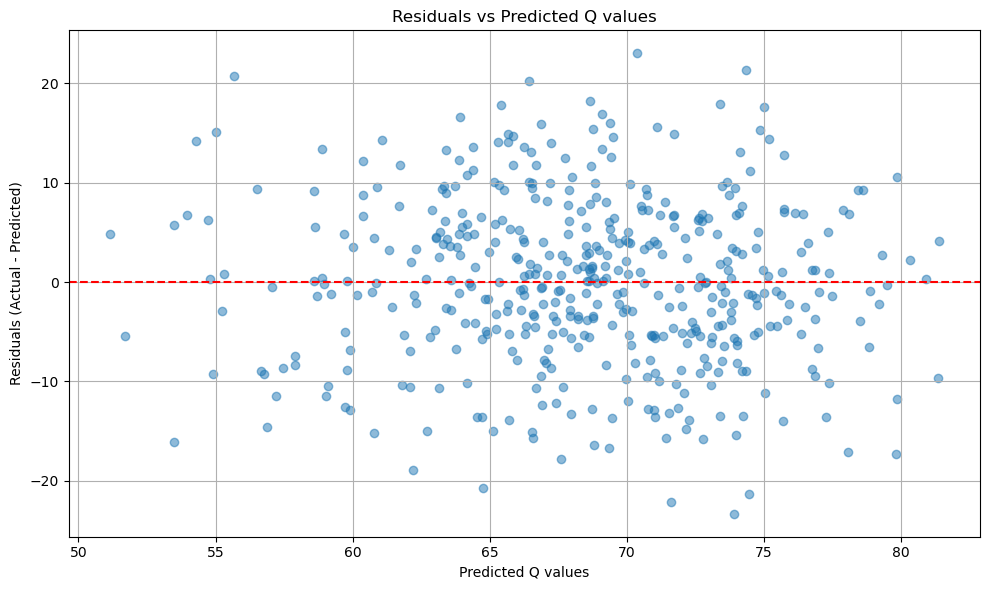

In [106]:


# Assuming you have already:
# y_test = true labels
# y_test_pred = model predictions

# Calculate residuals
residuals = y_test - y_test_pred

# Scatter plot: Residuals vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')  # Reference line at residual=0
plt.xlabel('Predicted Q values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residuals vs Predicted Q values')
plt.grid(True)
plt.tight_layout()
plt.show()


### Plot Details
- **X-axis**: Predicted Q values  
- **Y-axis**: Residuals (Actual − Predicted)  
- Visualizes both the spread and central tendency of errors across the prediction space.

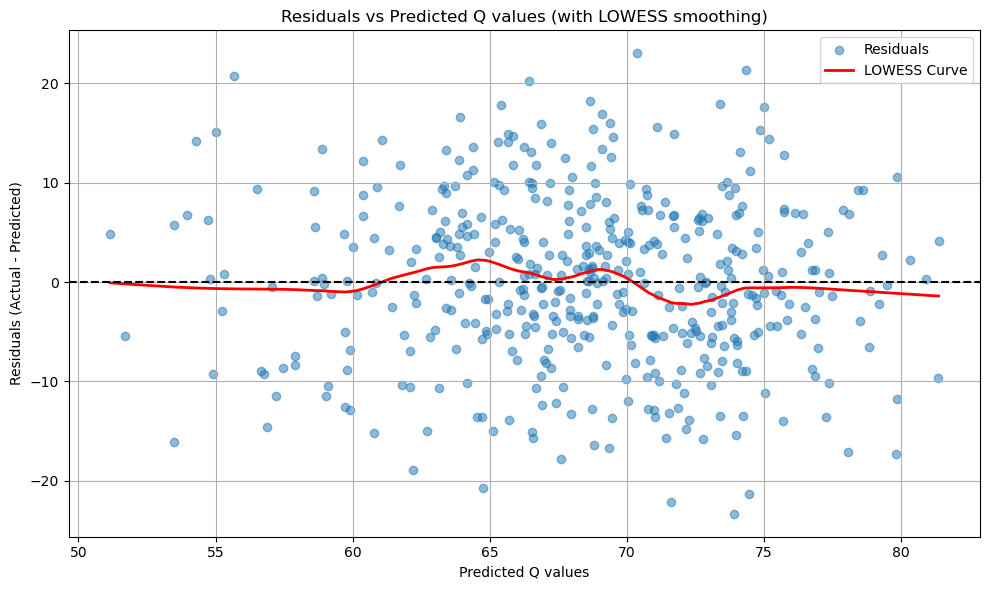

In [109]:


# Assume you have already computed:
# y_test: true Q values
# y_test_pred: predicted Q values

residuals = y_test - y_test_pred

# Create a LOWESS smoothing
lowess = sm.nonparametric.lowess
smoothed = lowess(residuals, y_test_pred, frac=0.3)  # frac controls the smoothing

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred, residuals, alpha=0.5, label='Residuals')
plt.plot(smoothed[:, 0], smoothed[:, 1], color='red', linewidth=2, label='LOWESS Curve')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Predicted Q values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residuals vs Predicted Q values (with LOWESS smoothing)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Cumulative Feature Importance Selection
### Method Overview
1. **Sort features** by descending importance.
2. Compute **cumulative importance** for each feature.
3. Normalize cumulative importance to a 0–1 scale.
4. **Plot cumulative importance curve** to visually inspect the point of diminishing returns.
5. Select features up to the **95% cumulative threshold**.
### Results
- Selected top features that cumulatively explain **95%** of the model's learned importance
- Final number of features used: *`X`*

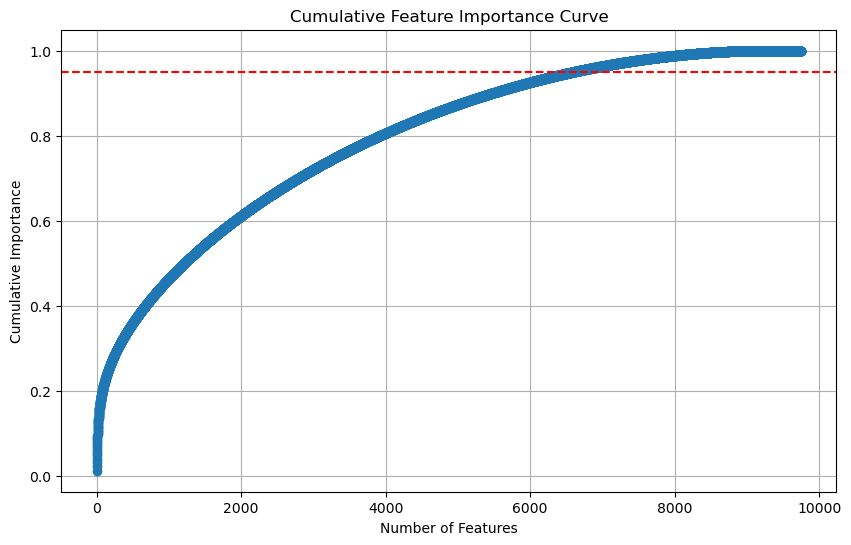

Number of features selected to explain 95% importance: 6593


In [110]:
# --- Cumulative Feature Importance Selection ---

# Sort by importance descending
sorted_importance_df = best_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Calculate cumulative importance
sorted_importance_df['Cumulative_Importance'] = sorted_importance_df['Importance'].cumsum()

# Normalize to [0,1] scale
total_importance = sorted_importance_df['Importance'].sum()
sorted_importance_df['Cumulative_Importance'] /= total_importance

# Plot cumulative importance curve
plt.figure(figsize=(10, 6))
plt.plot(sorted_importance_df.index, sorted_importance_df['Cumulative_Importance'], marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.title('Cumulative Feature Importance Curve')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--')
plt.show()

# Select features explaining 95% cumulative importance
selected_features_cumulative = sorted_importance_df[sorted_importance_df['Cumulative_Importance'] <= 0.95]['Feature'].tolist()

print(f"Number of features selected to explain 95% importance: {len(selected_features_cumulative)}")

# --- Prepare X and y based on selected features ---

# Drop Q, B columns
X_all_features = filtered_genotype_df.drop(columns=['Q', 'B'])
y = filtered_genotype_df['Q']

# Select the top features
X_selected = X_all_features[selected_features_cumulative]

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Standardize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [111]:
# --- Training Random Forest on 95% Cumulative Importance Features ---

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=25,
    max_features='sqrt',
    min_samples_split=15,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_scaled, y_train)

# Predictions
y_train_pred = rf.predict(X_train_scaled)
y_test_pred = rf.predict(X_test_scaled)

# Evaluation
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print(f"Train R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Train MSE: {train_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}")


Train R²: 0.7270
Test R²: 0.2734
Train MSE: 27.9050
Test MSE: 69.6963


## Threshold-Based Feature Selection for Stacking Model
### Methodology
1. Defined a range of **20 thresholds** from `0.0001` to `0.002`
2. For each threshold:
   - Selected SNPs with importance ≥ threshold
   - Trained a **StackingRegressor** with:
     - **Base Models**:
       - `LassoCV`
       - `ElasticNetCV`
       - `SVR (RBF Kernel)`
     - **Meta Model**:
       - `RandomForestRegressor`
   - Evaluated performance using **Test MSE**

### Result Interpretation
- **X-axis**: Number of SNPs selected at each threshold  
- **Y-axis**: Corresponding **Test MSE** from the stacking model  
- Goal: Identify a sweet spot where minimal features achieve low error without overfitting

---

### Visualization
The curve helps determine how feature count impacts model performance, and where additional SNPs **stop improving** the prediction quality.

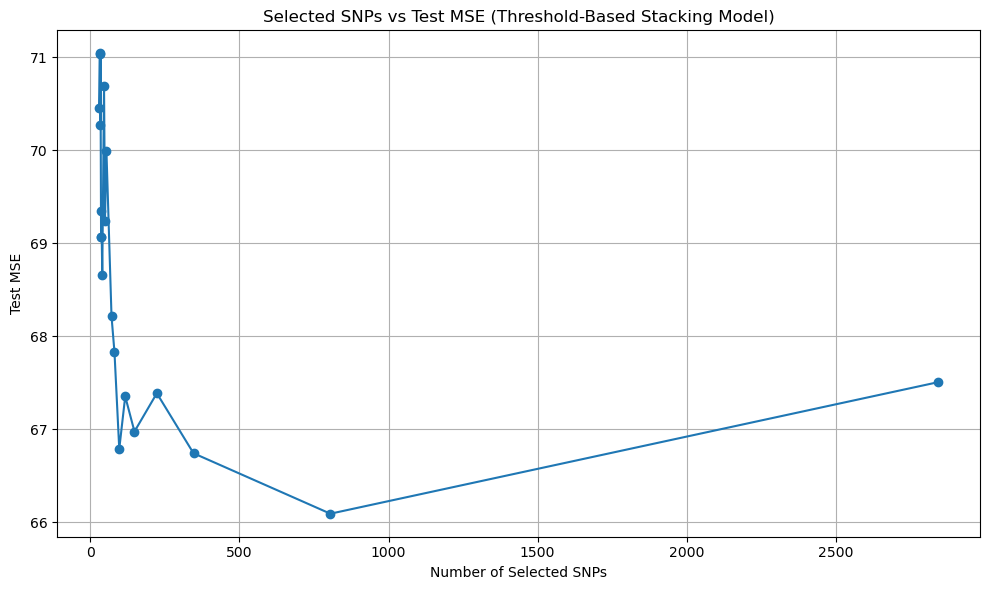

In [112]:
# --- Define thresholds to test ---
thresholds = np.linspace(0.0001, 0.002, 20)

# --- Store results ---
stacking_results = []

for thresh in thresholds:
    # Select features above threshold
    selected_features = best_importance_df[best_importance_df['Importance'] >= thresh]['Feature'].tolist()
    if len(selected_features) == 0:
        continue

    # Prepare data
    X_all = filtered_genotype_df.drop(columns=['Q', 'B'])
    y = filtered_genotype_df['Q']
    X_selected = X_all[selected_features]

    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define base and meta models
    base_models = [
        ('lasso', LassoCV(cv=5, max_iter=50000, tol=1e-2)),
        ('enet', ElasticNetCV(cv=5, max_iter=50000, tol=1e-2)),
        ('svr', SVR(kernel='rbf', C=1.0, epsilon=0.1))
    ]

    meta_model = RandomForestRegressor(
        n_estimators=200,
        max_depth=25,
        max_features='sqrt',
        min_samples_split=15,
        random_state=42,
        n_jobs=-1
    )

    stacked_model = StackingRegressor(
        estimators=base_models,
        final_estimator=meta_model,
        passthrough=True,
        n_jobs=-1
    )

    try:
        stacked_model.fit(X_train_scaled, y_train)
        y_test_pred = stacked_model.predict(X_test_scaled)
        test_mse = mean_squared_error(y_test, y_test_pred)
        stacking_results.append((thresh, len(selected_features), test_mse))
    except Exception as e:
        print(f"Error at threshold {thresh}: {e}")

# --- Convert to DataFrame and Plot ---
stacking_df = pd.DataFrame(stacking_results, columns=['Threshold', 'Num_Selected_SNPs', 'Test_MSE'])

plt.figure(figsize=(10, 6))
plt.plot(stacking_df['Num_Selected_SNPs'], stacking_df['Test_MSE'], marker='o')
plt.xlabel('Number of Selected SNPs')
plt.ylabel('Test MSE')
plt.title('Selected SNPs vs Test MSE (Threshold-Based Stacking Model)')
plt.grid(True)
plt.tight_layout()
plt.show()


## Final Stacking Regressor: Top 50 SNPs (Lasso + ElasticNet)
### Model Architecture

**Base Models**:
- `LassoCV`: Penalized linear regression encouraging sparsity
- `ElasticNetCV`: Combination of L1 and L2 regularization

**Meta Model**:
- `RandomForestRegressor`:
  - `n_estimators = 200`
  - `max_depth = 25`
  - `max_features = sqrt`
  - `min_samples_split = 15`

**Stacking Configuration**:
- `passthrough=True` (passes original features to meta-model)
- `n_jobs=-1` for parallel training


In [116]:
# --- Step 1: Select Top 50 Features ---
best_importance_df = rf_results['feature_importance'].copy()
top_50_features = best_importance_df.head(100)['Feature'].tolist()

# --- Step 2: Prepare Data ---
X_all = filtered_genotype_df.drop(columns=['Q', 'B'])
y = filtered_genotype_df['Q']
X_selected = X_all[top_50_features]

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Step 3: Define Base Models (without SVR) ---
base_models = [
    ('lasso', LassoCV(cv=5, max_iter=50000, tol=1e-2)),
    ('enet', ElasticNetCV(cv=5, max_iter=50000, tol=1e-2))
]

# --- Step 4: Define Meta-Model ---
meta_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=25,
    max_features='sqrt',
    min_samples_split=15,
    random_state=42,
    n_jobs=-1
)

# --- Step 5: Build and Train Stacking Regressor ---
stacked_model = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model,
    passthrough=True,
    n_jobs=-1
)

start_time = time.time()
stacked_model.fit(X_train_scaled, y_train)
training_time = time.time() - start_time

# --- Step 6: Evaluate ---
y_train_pred = stacked_model.predict(X_train_scaled)
y_test_pred = stacked_model.predict(X_test_scaled)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print("\n===== Stacking Regressor (Top 50 SNPs) Results =====")
print(f"Train R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Train MSE: {train_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Training Time: {training_time:.2f} seconds")


===== Stacking Regressor (Top 50 SNPs) Results =====
Train R²: 0.6519
Test R²: 0.3022
Train MSE: 35.5783
Test MSE: 66.9379
Training Time: 0.53 seconds


## Results Summary: Stacking Regressor on Top 50 SNPs

### Performance Metrics

| Metric        | Value       |
|---------------|-------------|
| **Train R²**  | 0.6519      |
| **Test R²**   | 0.3022      |
| **Train MSE** | 35.5783     |
| **Test MSE**  | 66.9379     |
| **Training Time** | 0.53 seconds |

---

### Interpretation & Conclusion

- **Moderate Train R² (0.65)** suggests that the model captures a fair amount of variance in the training data.
- **Lower Test R² (0.30)** indicates some **drop in generalization**, pointing to potential **mild overfitting** or **model bias**.
- Using only **50 SNPs**, the model keeps things computationally light (**0.53 seconds**), while still offering **reasonable predictive power**.
- 💡 The **linear base models** (Lasso, ElasticNet) offer strong interpretability, and the **Random Forest meta-model** helps catch any non-linear residual trends.

---

## Stacked Regressor: Performance vs Top N SNP Features
### Model Configuration

- **Base Models**:
  - `LassoCV`
  - `ElasticNetCV`
  - `SVR (RBF Kernel)`

- **Meta Model**:
  - `RandomForestRegressor`  
    (200 trees, max depth = 25, min samples split = 15, max features = sqrt)

- **Ensemble Strategy**:  
  `StackingRegressor(passthrough=True)` to include original inputs alongside base model predictions

---

### Results Summary

| Top N Features | Train R² | Test R² | Train MSE | Test MSE | Time (s) |
|----------------|----------|---------|-----------|----------|----------|
| 10             | 0.4262   | 0.1941  | 58.65     | 77.31    | 0.29     |
| 50             | 0.6081   | 0.2833  | 40.06     | 68.75    | 0.30     |
| 100            | 0.6551   | 0.3031  | 35.25     | 66.85    | 0.56     |
| 200            | 0.6855   | 0.3026  | 32.15     | 66.90    | 1.03     |
| 300            | 0.6997   | 0.3064  | 30.69     | 66.53    | 2.39     |
| 500            | 0.7117   | 0.3108  | 29.47     | 66.11    | 4.71     |

Full results include more granular intervals up to 500 SNPs.

---

### Key Observations from the Plot

- **Test R² plateaus** around ~0.31 after the top 100–150 features.
- **Train R² steadily increases**, indicating improved fit with more features — but **marginal generalization gain**.
- **Test MSE** slightly decreases, but the **rate of improvement diminishes** with each additional 50–100 SNPs.
- **Training time increases sharply** after 250–300 features.

### Conclusion

- **Top ~100 SNPs** offer a strong balance between performance and efficiency.
- Adding more features beyond this gives **diminishing returns** and **increased computational cost**.
- A cutoff around **100–150 SNPs** is recommended for practical modeling without sacrificing much performance.

    Top_N_Features  Train R2   Test R2  Train MSE   Test MSE  Training Time
0               10  0.426221  0.194112  58.647789  77.305469       0.292343
1               20  0.513746  0.237674  49.701566  73.126719       0.267587
2               30  0.560605  0.258641  44.911979  71.115446       0.289607
3               50  0.608086  0.283286  40.058803  68.751351       0.303828
4               75  0.632961  0.285721  37.516183  68.517775       0.537729
5              100  0.655142  0.303144  35.249056  66.846463       0.564854
6              150  0.675114  0.298589  33.207649  67.283387       0.748030
7              200  0.685469  0.302583  32.149157  66.900258       1.028660
8              250  0.692526  0.304617  31.427897  66.705151       1.320182
9              300  0.699704  0.306434  30.694217  66.530856       2.392226
10             350  0.705817  0.305075  30.069415  66.661294       3.194856
11             400  0.710631  0.305356  29.577283  66.634285       3.618153
12          

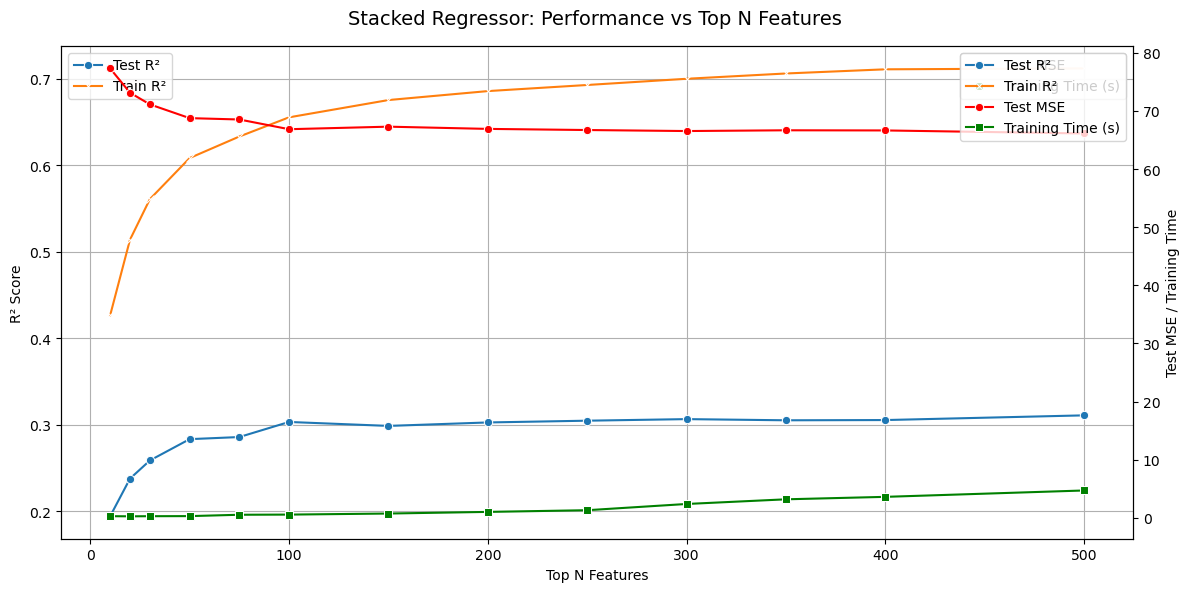

In [117]:


# --- Step 1: Feature Importance Sorted ---
best_importance_df = rf_results['feature_importance'].copy()
sorted_importance_df = best_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# --- Step 2: Prepare Data ---
X_all = filtered_genotype_df.drop(columns=['Q', 'B'])
y = filtered_genotype_df['Q']

# --- Step 3: Define Base Models and Meta-Model ---
base_models = [
    ('lasso', LassoCV(cv=5, max_iter=50000, tol=1e-2)),
    ('enet', ElasticNetCV(cv=5, max_iter=50000, tol=1e-2)),
    ('svr', SVR(kernel='rbf', C=1.0, epsilon=0.1))
]

meta_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=25,
    max_features='sqrt',
    min_samples_split=15,
    random_state=42,
    n_jobs=-1
)

stacked_model_template = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model,
    passthrough=True,
    n_jobs=-1
)

# --- Step 4: Evaluate Model for Varying Top N Features ---
top_n_values = [10, 20, 30, 50, 75, 100, 150, 200, 250, 300, 350, 400, 500]
results = []

for n in top_n_values:
    selected_features = sorted_importance_df['Feature'].iloc[:n].tolist()
    X_selected = X_all[selected_features]

    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = stacked_model_template
    start = time.time()
    model.fit(X_train_scaled, y_train)
    duration = time.time() - start

    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)

    results.append({
        'Top_N_Features': n,
        'Train R2': r2_score(y_train, y_train_pred),
        'Test R2': r2_score(y_test, y_test_pred),
        'Train MSE': mean_squared_error(y_train, y_train_pred),
        'Test MSE': mean_squared_error(y_test, y_test_pred),
        'Training Time': duration
    })

# --- Step 5: Convert to DataFrame and Plot ---
results_df = pd.DataFrame(results)

import matplotlib.ticker as ticker

fig, ax1 = plt.subplots(figsize=(12, 6))

sns.lineplot(data=results_df, x='Top_N_Features', y='Test R2', marker='o', label='Test R²', ax=ax1)
sns.lineplot(data=results_df, x='Top_N_Features', y='Train R2', marker='x', label='Train R²', ax=ax1)
ax1.set_ylabel("R² Score")
ax1.set_xlabel("Top N Features")
ax1.grid(True)

ax2 = ax1.twinx()
sns.lineplot(data=results_df, x='Top_N_Features', y='Test MSE', marker='o', label='Test MSE', ax=ax2, color='red')
sns.lineplot(data=results_df, x='Top_N_Features', y='Training Time', marker='s', label='Training Time (s)', ax=ax2, color='green')
ax2.set_ylabel("Test MSE / Training Time")

fig.suptitle("Stacked Regressor: Performance vs Top N Features", fontsize=14)
fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)

plt.tight_layout()
print(results_df)

plt.show()


## SNP Selection via Extra Trees & Mutual Information
### Methodology

1. **Selectors Implemented**:
   - `ExtraTreesSelector`: Uses feature importances from `ExtraTreesRegressor`
   - `MutualInformationSelector`: Uses `mutual_info_regression` from `sklearn`

2. **Evaluation Strategy**:
   - 5-Fold Cross-Validation using `RandomForestRegressor`
   - Metrics:
     - **Mean R²** (goodness of fit)
     - **Mean MSE** (prediction error)
   - Feature counts tested: **100, 200, 300, 400, 500**

In [118]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger("SNP_Selector")

RANDOM_STATE = 42

class GenomicSNPSelector:
    def __init__(self, n_features_to_select=300):
        self.n_features_to_select = n_features_to_select
        self.feature_importances_ = None
        self.selected_indices_ = None
        self.method_name = "Base"

    def fit(self, X, y):
        raise NotImplementedError

    def get_selected_features(self):
        return self.selected_indices_

    def get_feature_importance(self):
        return self.feature_importances_

class ExtraTreesSelector(GenomicSNPSelector):
    def __init__(self, n_features_to_select=300):
        super().__init__(n_features_to_select)
        self.model = ExtraTreesRegressor(
            n_estimators=100,
            random_state=RANDOM_STATE,
            n_jobs=-1
        )

    def fit(self, X, y):
        logger.info("Fitting Extra Trees Regressor for feature selection...")
        self.model.fit(X, y)
        self.feature_importances_ = self.model.feature_importances_
        self.selected_indices_ = np.argsort(self.feature_importances_)[::-1][:self.n_features_to_select]
        return self

class MutualInformationSelector(GenomicSNPSelector):
    def __init__(self, n_features_to_select=300):
        super().__init__(n_features_to_select)

    def fit(self, X, y):
        logger.info("Computing mutual information for feature selection...")
        self.feature_importances_ = mutual_info_regression(X, y, random_state=RANDOM_STATE)
        self.selected_indices_ = np.argsort(self.feature_importances_)[::-1][:self.n_features_to_select]
        return self

def evaluate_rf(X, y, selected_indices, cv=5):
    if len(selected_indices) == 0:
        return {"train_r2": 0, "test_r2": 0, "train_mse": 0, "test_mse": 0, "n_features": 0}

    from sklearn.ensemble import RandomForestRegressor
    kf = KFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)

    r2_scores, mse_scores = [], []
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx][:, selected_indices], X[test_idx][:, selected_indices]
        y_train, y_test = y[train_idx], y[test_idx]

        model = RandomForestRegressor(
            n_estimators=200,
            max_depth=25,
            max_features='sqrt',
            min_samples_split=15,
            random_state=RANDOM_STATE,
            n_jobs=-1
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2_scores.append(r2_score(y_test, y_pred))
        mse_scores.append(mean_squared_error(y_test, y_pred))

    return {
        "mean_r2": np.mean(r2_scores),
        "mean_mse": np.mean(mse_scores),
        "n_features": len(selected_indices)
    }

In [119]:
X = filtered_genotype_df.drop(columns=['Q', 'B']).to_numpy(dtype='float64')  # SNP matrix
y = filtered_genotype_df['Q'].to_numpy(dtype='float64')  # Quantitative trait

selector = ExtraTreesSelector(n_features_to_select=300)
selector.fit(X, y)

selected_indices = selector.get_selected_features()         # indices of selected SNPs
feature_importances = selector.get_feature_importance()

results = evaluate_rf(X, y, selected_indices)
print(f"R²: {results['mean_r2']:.4f} | MSE: {results['mean_mse']:.4f} | Features: {results['n_features']}")

snp_names = filtered_genotype_df.drop(columns=['Q', 'B']).columns
selected_snps = snp_names[selected_indices]

2025-05-09 14:16:22,566 - INFO - Fitting Extra Trees Regressor for feature selection...


R²: 0.3524 | MSE: 65.3095 | Features: 300


In [120]:
X = filtered_genotype_df.drop(columns=['Q', 'B']).to_numpy(dtype='float64')  # SNP matrix
y = filtered_genotype_df['Q'].to_numpy(dtype='float64')  # Quantitative trait

selector = MutualInformationSelector(n_features_to_select=300)
selector.fit(X, y)

selected_indices = selector.get_selected_features()         # indices of selected SNPs
feature_importances = selector.get_feature_importance()

results = evaluate_rf(X, y, selected_indices)
print(f"R²: {results['mean_r2']:.4f} | MSE: {results['mean_mse']:.4f} | Features: {results['n_features']}")

snp_names = filtered_genotype_df.drop(columns=['Q', 'B']).columns
selected_snps = snp_names[selected_indices]

2025-05-09 14:16:50,505 - INFO - Computing mutual information for feature selection...


R²: 0.3178 | MSE: 68.7829 | Features: 300


In [121]:
feature_counts = [100, 200, 300, 400, 500]
methods = {
    'ExtraTrees': ExtraTreesSelector,
    'MutualInfo': MutualInformationSelector
}

X = filtered_genotype_df.drop(columns=['Q', 'B']).to_numpy(dtype='float64')
y = filtered_genotype_df['Q'].to_numpy(dtype='float64')

results = []

for method_name, SelectorClass in methods.items():
    for n in feature_counts:
        selector = SelectorClass(n_features_to_select=n)
        selector.fit(X, y)
        selected_indices = selector.get_selected_features()
        eval_metrics = evaluate_rf(X, y, selected_indices)
        results.append({
            'Method': method_name,
            'Num_SNPs': n,
            'R2': eval_metrics['mean_r2'],
            'MSE': eval_metrics['mean_mse']
        })


2025-05-09 14:17:24,483 - INFO - Fitting Extra Trees Regressor for feature selection...
2025-05-09 14:17:52,133 - INFO - Fitting Extra Trees Regressor for feature selection...
2025-05-09 14:18:19,999 - INFO - Fitting Extra Trees Regressor for feature selection...
2025-05-09 14:18:47,722 - INFO - Fitting Extra Trees Regressor for feature selection...
2025-05-09 14:19:15,495 - INFO - Fitting Extra Trees Regressor for feature selection...
2025-05-09 14:19:44,241 - INFO - Computing mutual information for feature selection...
2025-05-09 14:20:17,919 - INFO - Computing mutual information for feature selection...
2025-05-09 14:20:51,489 - INFO - Computing mutual information for feature selection...
2025-05-09 14:21:24,828 - INFO - Computing mutual information for feature selection...
2025-05-09 14:24:53,964 - INFO - Computing mutual information for feature selection...


## Comparison of SNP Selection Methods: Extra Trees vs Mutual Information
### Performance Overview

#### Top Plot: **R² Score vs Number of Selected SNPs**
- **Extra Trees** consistently outperforms Mutual Information in terms of **mean R²** across all SNP counts.
- The R² score for Extra Trees slightly **declines with more features**, suggesting that top-ranked features carry most of the signal.
- **Mutual Information** shows a minor peak at 200 SNPs but remains ~0.03–0.05 lower than Extra Trees.

#### Bottom Plot: **MSE vs Number of Selected SNPs**
- Extra Trees again leads with a lower **mean MSE** throughout.
- The **MSE for Mutual Information increases** as more features are added — indicating potential inclusion of noisy or redundant SNPs.
- Extra Trees’ MSE remains fairly **stable** beyond 300 SNPs.

---

### Key Takeaways
- **Extra Trees** provides more stable and accurate SNP selection, both in terms of R² and MSE.
- **Mutual Information** may capture some non-linear dependencies, but lacks robustness to feature redundancy.
- The **best performance sweet spot** for Extra Trees lies around **100–200 SNPs**.

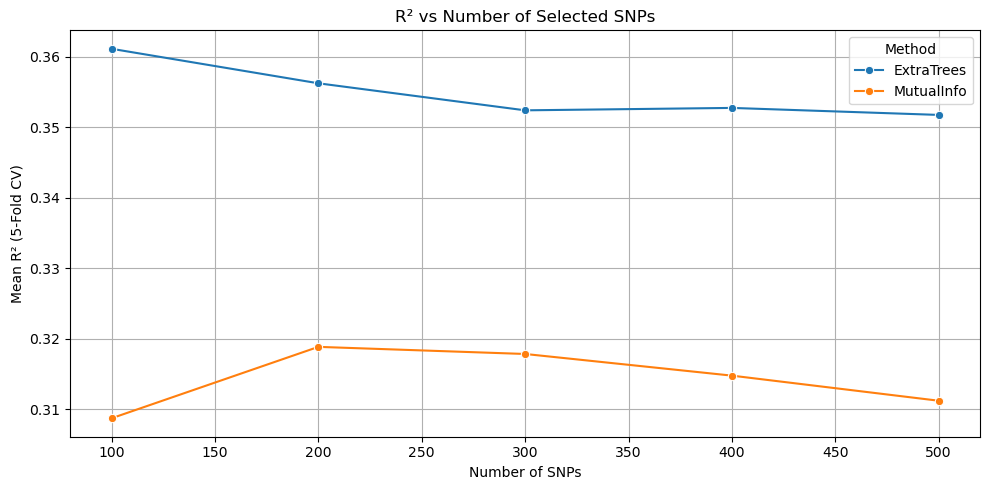

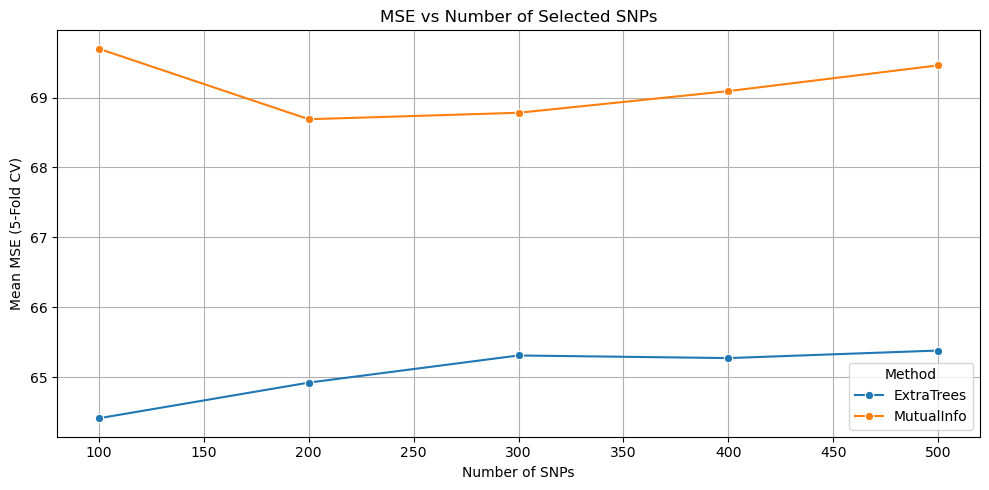

In [122]:
results_df = pd.DataFrame(results)

# R² Plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=results_df, x='Num_SNPs', y='R2', hue='Method', marker='o')
plt.title('R² vs Number of Selected SNPs')
plt.xlabel('Number of SNPs')
plt.ylabel('Mean R² (5-Fold CV)')
plt.grid(True)
plt.tight_layout()
plt.show()

# MSE Plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=results_df, x='Num_SNPs', y='MSE', hue='Method', marker='o')
plt.title('MSE vs Number of Selected SNPs')
plt.xlabel('Number of SNPs')
plt.ylabel('Mean MSE (5-Fold CV)')
plt.grid(True)
plt.tight_layout()
plt.show()


## Final SNP Selection & Export Summary
### Best SNP Count per Method (Based on R²)

| Method       | Num SNPs | R²       | MSE       |
|--------------|----------|----------|-----------|
| ExtraTrees   | 100      | 0.3611   | 64.41     |
| MutualInfo   | 200      | 0.3189   | 68.69     |

- **Extra Trees** with 100 SNPs gave the **best overall performance**
- **Mutual Information** peaked at 200 SNPs but lagged behind in R² and MSE

In [123]:
# Find best R² for each method
best_by_method = results_df.sort_values('R2', ascending=False).groupby('Method').first().reset_index()

print("Best SNP count per method:")
print(best_by_method)

# Get original SNP names
snp_names = filtered_genotype_df.drop(columns=['Q', 'B']).columns

# Loop through each best config and save the selected SNPs
for _, row in best_by_method.iterrows():
    method = row['Method']
    n = int(row['Num_SNPs'])

    # Refit selector to get the selected indices
    if method == 'ExtraTrees':
        selector = ExtraTreesSelector(n_features_to_select=n)
    elif method == 'MutualInfo':
        selector = MutualInformationSelector(n_features_to_select=n)

    selector.fit(X, y)
    selected_indices = selector.get_selected_features()
    selected_snp_names = snp_names[selected_indices]

    # Save to CSV
    filename = f"best_{method.lower()}_{n}_snps.csv"
    selected_snp_names.to_series().to_csv(filename, index=False)
    print(f"Saved {len(selected_snp_names)} SNPs to {filename}")


2025-05-09 14:25:26,573 - INFO - Fitting Extra Trees Regressor for feature selection...


Best SNP count per method:
       Method  Num_SNPs        R2        MSE
0  ExtraTrees       100  0.361112  64.410925
1  MutualInfo       200  0.318851  68.690608


2025-05-09 14:25:52,285 - INFO - Computing mutual information for feature selection...


Saved 100 SNPs to best_extratrees_100_snps.csv
Saved 200 SNPs to best_mutualinfo_200_snps.csv
